# Multi-label Legal Text Classification for CIA

## Models and Experiments: Baseline Models

*Note: all codes in this section are self-written unless otherwise stated. When necessary, debugging was conducted with the help of ChatGPT and Stackoverflow.*

In [ ]:
!pip install umap-learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv

In [2]:
from functions.source_parsing import *
from zipfile import ZipFile
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from nltk.tokenize import sent_tokenize, word_tokenize
from numpy.linalg import norm
import umap.umap_ as umap

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RepeatedKFold
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/janinedevera/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/janinedevera/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.chdir("../..")
os.getcwd()

'/Users/janinedevera/Documents/School/MDS 2021-2023/Thesis/multilabel-legal-text-classification-CIA'

### Preliminaries

Load data

In [4]:
# legal text, labeled
text = pd.read_csv("data/01 legal_texts_pipeline_stopwords.csv", index_col=0)
text_labels = pd.read_csv("data/01 legal_texts_with_labels_grouped_split.csv", index_col=0)

# augmented training set and raw test set
train_df_aug = pd.read_csv("data/01 train_data_augmented.csv", index_col=0)
test_df = pd.read_csv("data/01 test_data.csv", index_col=0)

# definitions
defs = pd.read_csv("data/02 oecd_definitions_stopwords.csv", index_col=0)
defs_grouped = pd.read_csv("data/02 oecd_definitions_stopwords_grouped.csv", index_col=0)

In [5]:
defs_grouped['Main'] = defs_grouped['Main'].replace('D', 'Others')
defs_grouped

Main                                         text_clean  length
0       A  limit the number of supplier lead to the risk ...     833
1       B  regul can affect a supplier 's abil to compet ...     781
2       C  regul can affect supplier behaviour by not onl...     459
3  Others  regul sometim limit choic avail to consum for ...     257

In [6]:
text_labels.Category_New.value_counts()

A         1251
None       750
B          227
Others      71
C           59
Name: Category_New, dtype: int64

In [7]:
train_df_aug.Category_New.value_counts()

B         894
Others    743
C         662
A         624
None      522
Name: Category_New, dtype: int64

In [8]:
test_df.Category_New.value_counts()

A         376
None      225
B          68
Others     21
C          18
Name: Category_New, dtype: int64

In [9]:
# pre-process text (lemmatization only)
train_df_aug['text_clean'] = preprocess_corpus_keep_stop_words(train_df_aug['Text'])
train_df_aug['text_clean'] = [lemmatize(text) for text in train_df_aug['text_clean']]

test_df['text_clean'] = preprocess_corpus_keep_stop_words(test_df['Text'])
test_df['text_clean'] = [lemmatize(text) for text in test_df['text_clean']]

In [10]:
# create binary_label column
train_df_aug['binary_label'] = train_df_aug['Category_New'].apply(lambda x: 0 if x == "None" else 1)
test_df['binary_label'] = test_df['Category_New'].apply(lambda x: 0 if x == "None" else 1)

In [11]:
train_df_binary = train_df_aug
train_df_binary = train_df_binary.drop_duplicates(subset=('text_clean', 'binary_label'), keep='first').reset_index()

test_df_binary = test_df
test_df_binary = test_df_binary.drop_duplicates(subset=('text_clean', 'binary_label'), keep='first').reset_index()

In [12]:
train_df_binary['binary_label'].value_counts()

1    2789
0     521
Name: binary_label, dtype: int64

Define color palette

In [13]:
custom_cmap_blues = sns.color_palette(['#A9BBD3', '#A0B4CF', '#8FA8C6', '#7E9CBD', '#6D8FB4', '#537CA6', '#416F9D', '#306294', '#0F4A82'])
custom_cmap_pinks = sns.color_palette(['#FFE6F2', '#FFCCE4', '#F99FC8', '#F28AB9', '#E177A5', '#D56997', '#C85B89', '#B9537E'])

two_colors = sns.color_palette(['#C85B89', '#306294'])

### I. Logistic Regression (binary classification)

#### A. Unigrams TF-IDF

Manually define words to be excluded from features (e.g. stopwords, industry words)

In [14]:
# remove industry indicators
exclude_words = ['aircraft', 'port', 'aeronautical', 'resolution', 'paragraph', 'aerodome', 'animal', 'aviation',
                 'airport', 'air', 'sipaer', 'shipping', 'gazette', 'ordinance', 'date', 'effect', 'september', 
                 'aeronautics', 'transport', 'vessel', '79', '36', '139', '601', 'b', 'o', 's', 'la', 'ha',
                 'state', 'not', 'no', 'decree', 'norm', 'ley', 'de', 'provision',
                 'specifically', 'line', 'farming', 'livestock', 'only', 'there', 'mexico', 'city',
                 'ship', 'mexican', 'brazilian', 'art', 'article', 'project', 'law', 'study', 'civil', 'investigation',
                 'will',  'or', 'of', 'in', 'into', 'and', 'the', 'be', 'to', 'for', 'by', 'this', 'that', 'a', 'an',
                 'is', 'are',  'with', 'on', 'it', 'at' , 'may', 'must', 'from', 'section', 'page', 'after']

Construct document feature matrix

In [15]:
# tf-idf vectorizer
vectorizer = TfidfVectorizer(stop_words=exclude_words)

# n-grams vectorizer
ngram_vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', sublinear_tf=True, strip_accents='unicode', 
                                  stop_words=exclude_words, ngram_range=(2, 3))

In [16]:
def get_dfm(vectorizer, train_df, test_df):
    combined_text = pd.concat([train_df['text_clean'], test_df['text_clean']], axis=0)
    vectorizer.fit(combined_text)
    dfm_train = vectorizer.transform(train_df['text_clean'])
    dfm_test = vectorizer.transform(test_df['text_clean'])

    print('train dfm shape: ' + str(dfm_train.shape) + ' | test dfm shape:' + str(dfm_test.shape))

    return dfm_train, dfm_test

In [17]:
dfm_train, dfm_test = get_dfm(vectorizer, train_df_binary, test_df_binary)

train dfm shape: (3310, 5268) | test dfm shape:(613, 5268)


In [ ]:
# document feature matrix for training and test sets
#dfm_train = vectorizer.fit_transform(train_df_binary['text_clean'])
#dfm_test = vectorizer.fit_transform(test_df_binary['text_clean'])

#print('train dfm shape: ' + str(dfm_train.shape) + ' | test dfm shape:' + str(dfm_test.shape))

Train model

In [18]:
def logistic_train(train_text, train_labels, test_text, test_labels):
    scaler = StandardScaler(with_mean=False)
    train_text_scaled = scaler.fit_transform(train_text)
    test_text_scaled = scaler.transform(test_text)

    # train model and return training accuracy
    model = LogisticRegression(random_state=999, max_iter=1000).fit(train_text_scaled, train_labels)
    with open('./models/'+str(model)+'.pkl', 'wb') as f: pickle.dump(model, f)

    train_acc = model.score(train_text_scaled, train_labels)

    # evaluate on test data 
    y_pred = model.predict(test_text_scaled)
    classification_rep = classification_report(test_labels, y_pred, zero_division=0)
    test_acc = model.score(test_text_scaled, test_labels)

    # print classification report
    print(' Classification Report:')
    print(classification_rep)
    print('Train vs Test Accuracy:')
    print('Train:' + str(round(train_acc, 3)))
    print('Test:' + str(round(test_acc, 3)))

    return model, y_pred

In [19]:
train_text, train_labels, test_text, test_labels = dfm_train, train_df_binary['binary_label'], dfm_test, test_df_binary['binary_label']

In [20]:
lg, y_pred = logistic_train(train_text, train_labels, test_text, test_labels)

 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.69      0.79       221
           1       0.85      0.97      0.90       392

    accuracy                           0.87       613
   macro avg       0.88      0.83      0.84       613
weighted avg       0.87      0.87      0.86       613

Train vs Test Accuracy:
Train:0.999
Test:0.866


In [21]:
def plot_cm(labels, predictions, model):
    cm = confusion_matrix(labels, predictions)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=model.classes_, yticklabels=model.classes_,
            annot_kws={"fontfamily": "Arial", "fontsize": 12})
    plt.xlabel('predicted label', fontname='Arial', fontsize=13)
    plt.ylabel('true label', fontname='Arial', fontsize=13)
    plt.title('Confusion Matrix', fontname='Arial', fontsize=13)
    plt.xticks(fontname='Arial', fontsize=13)
    plt.yticks(fontname='Arial', fontsize=13)
    plt.show()

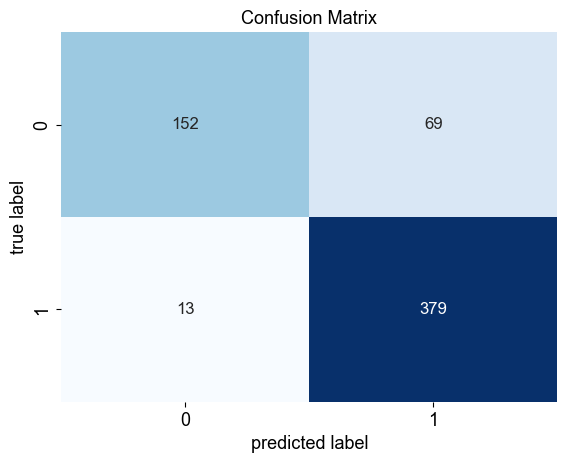

In [22]:
plot_cm(test_labels, y_pred, lg)

Feature importance

In [23]:
def get_features(vectorizer, model, n):
    feature_names = vectorizer.get_feature_names_out()

    # calculate feature importance
    importance = model.coef_[0]
    feature_importance = abs(importance)
    sorted_ids = feature_importance.argsort()[::-1]

    print('Top ' + str(n) + ' Important Bi-grams:')
    for i, ids in enumerate(sorted_ids[:n]):
        print(f"{i+1}. Features: {feature_names[ids]}, Importance: {feature_importance[ids]}")

    return feature_names, feature_importance

In [24]:
feature_names, feature_importance = get_features(vectorizer, lg, 10)

Top 10 Important Bi-grams:
1. Features: owner, Importance: 0.3328658850657057
2. Features: price, Importance: 0.29975334472448795
3. Features: market, Importance: 0.2577893443380964
4. Features: aerodrome, Importance: 0.2548904048633018
5. Features: pricing, Importance: 0.24540647455166834
6. Features: airworthiness, Importance: 0.24202765043840566
7. Features: general, Importance: 0.22675683276352954
8. Features: referred, Importance: 0.2264886615903782
9. Features: member, Importance: 0.22075450775111566
10. Features: these, Importance: 0.21530720563794914


In [25]:
def plot_features(names, scores, top_n, save_fig = False, file_name = None):
    sorted_importance = sorted(zip(scores, names), reverse=True)

    n_features = top_n
    top_n_importance = sorted_importance[:n_features]

    top_n_features = [f[1] for f in top_n_importance]
    top_n_values = [f[0] for f in top_n_importance]

    # plot
    plt.figure(figsize=(6, 8))
    plt.barh(range(n_features), top_n_values, align='center', color='#0C6291')
    plt.yticks(range(n_features), top_n_features)
    plt.xlabel('Coefficient', labelpad=12, fontname='Arial', fontsize=13)
    #plt.title('Feature Importance: Top 20 Feature', fontname='Arial', fontsize=16)
    plt.xticks(fontname='Arial', fontsize=13)
    plt.yticks(fontname='Arial', fontsize=13)
    plt.gca().invert_yaxis()

    if save_fig:
    # save the figure
        save_path = os.path.join('draft', 'images', file_name)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


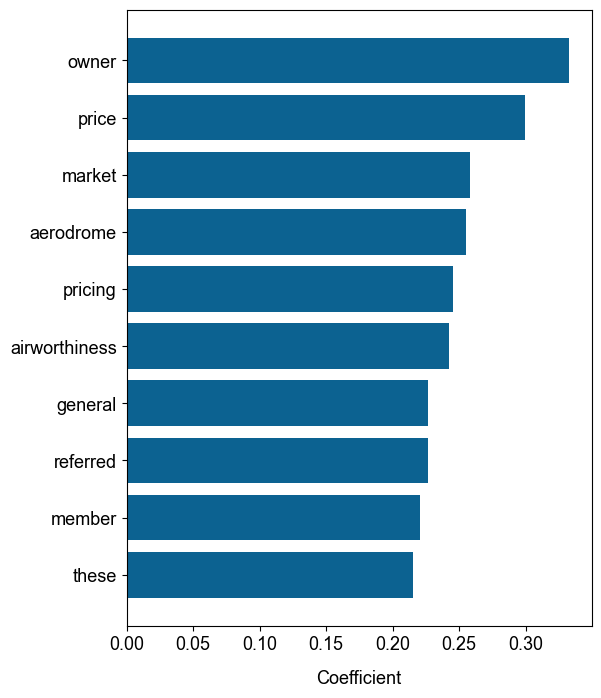

In [26]:
plot_features(feature_names, feature_importance, 10)

#### B. N-grams TF-IDF

In [349]:
dfm_train, dfm_test = get_dfm(ngram_vectorizer, train_df_binary, test_df_binary)

train dfm shape: (3310, 169149) | test dfm shape:(613, 169149)


In [350]:
train_text, train_labels, test_text, test_labels = dfm_train, train_df_binary['binary_label'], dfm_test, test_df_binary['binary_label']

In [351]:
lg_ngrams, y_pred = logistic_train(train_text, train_labels, test_text, test_labels)

 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.32      0.48       221
           1       0.72      1.00      0.84       392

    accuracy                           0.75       613
   macro avg       0.85      0.66      0.66       613
weighted avg       0.82      0.75      0.71       613

Train vs Test Accuracy:
Train:0.997
Test:0.754


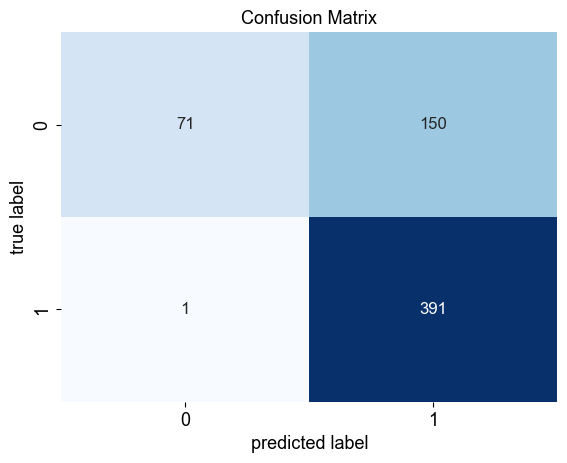

In [352]:
plot_cm(test_labels, y_pred, lg_ngrams)

In [355]:
feature_names, feature_importance = get_features(ngram_vectorizer, lg_ngrams, 10)

Top 20 Important Bi-grams:
1. Features: domestic market, Importance: 0.18185160567970904
2. Features: utical biotechnology, Importance: 0.168825735972454
3. Features: export market, Importance: 0.13959105230441107
4. Features: o owner, Importance: 0.1378601614151732
5. Features: go publication, Importance: 0.1352461080411887
6. Features: xternal peace, Importance: 0.12052722131997819
7. Features: s owner, Importance: 0.10918510039177663
8. Features: internal market, Importance: 0.10258542806534866
9. Features: decree no, Importance: 0.09886585221973364
10. Features: called linkage, Importance: 0.09749212367681506


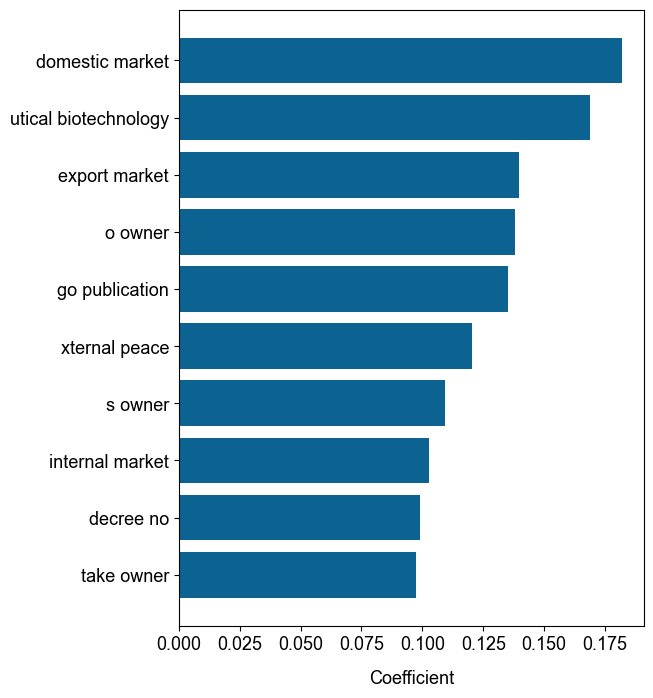

In [356]:
plot_features(feature_names, feature_importance, 10)

### II. Softmax Regression (multiclass classification)

##### A. Unigrams TF-IDF

In [811]:
dfm_train, dfm_test = get_dfm(vectorizer, train_df_aug, test_df)

train dfm shape: (3445, 5268) | test dfm shape:(708, 5268)


In [812]:
train_text, train_labels, test_text, test_labels = dfm_train, train_df_aug['Category_New'], dfm_test, test_df['Category_New']

Train model

In [23]:
def softmax_train(train_text, train_labels, test_text, test_labels):
    #scaler = StandardScaler(with_mean=False)
    #train_text_scaled = scaler.fit_transform(train_text)
    #test_text_scaled = scaler.transform(test_text)

    # train model and return training accuracy
    model = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', random_state=999, max_iter=1000).fit(train_text, train_labels)
    with open('./models/'+str(model)+'.pkl', 'wb') as f: pickle.dump(model, f)

    train_acc = model.score(train_text, train_labels)

    # evaluate on test data 
    y_pred = model.predict(test_text)
    classification_rep = classification_report(test_labels, y_pred, zero_division=0)
    test_acc = model.score(test_text, test_labels)

    # print classification report
    print(' Classification Report:')
    print(classification_rep)
    print('Train vs Test Accuracy:')
    print('Train:' + str(round(train_acc, 3)))
    print('Test:' + str(round(test_acc, 3)))

    return model, y_pred

In [814]:
sf, y_pred = softmax_train(train_text, train_labels, test_text, test_labels)

 Classification Report:
              precision    recall  f1-score   support

           A       0.88      0.74      0.80       376
           B       0.35      0.68      0.46        68
           C       0.42      0.44      0.43        18
        None       0.93      0.81      0.87       225
      Others       0.26      0.57      0.35        21

    accuracy                           0.74       708
   macro avg       0.57      0.65      0.58       708
weighted avg       0.82      0.74      0.77       708

Train vs Test Accuracy:
Train:0.937
Test:0.742


Feature importance

In [816]:
feature_names, feature_importance = get_features(vectorizer, sf, 10)

Top 10 Important Bi-grams:
1. Features: authorisation, Importance: 2.222992898517373
2. Features: medicine, Importance: 2.084558630777256
3. Features: price, Importance: 1.9255401769946472
4. Features: pilot, Importance: 1.8669603308962843
5. Features: brl, Importance: 1.8008917801116335
6. Features: international, Importance: 1.7645561438756763
7. Features: bidder, Importance: 1.7238633458529065
8. Features: firm, Importance: 1.6453597548293422
9. Features: tariff, Importance: 1.6037576096860697
10. Features: anp, Importance: 1.4930193765864295


Visualize classification report

In [24]:
def class_report_df(labels, predictions):
    report = classification_report(labels, predictions, zero_division=0, output_dict=True)

    categories = ['A', 'B', 'C', 'Others', 'None']
    metrics = ['precision', 'recall', 'f1-score']
    data = []
    for category in categories:
        row = []
        for metric in metrics:
            row.append(round(report[category][metric], 2))
        data.append(row)

    report_df = pd.DataFrame(data, columns=metrics, index=categories)

    return report_df

In [818]:
report = class_report_df(test_labels, y_pred)

In [25]:
def report_heatmap(report_df, file_name, color):
    plt.figure(figsize=(6, 8))
    sns.heatmap(report_df, annot=True, cmap=color, cbar=False, vmin=0, vmax=1,  fmt='.2f',
            annot_kws={"fontfamily": "Arial", "fontsize": 12})
    #plt.xlabel('Metrics', labelpad=12, fontname='Arial', fontsize=12)
    #plt.title('Classification report', fontname='Arial', fontsize=14, y=1.02)
    plt.xticks(fontname='Arial', fontsize=12)
    plt.yticks(fontname='Arial', fontsize=12, rotation=0)
    plt.tick_params(axis='y', length=0)
    plt.tick_params(axis='x', length=0)

    # save the figure
    save_path = os.path.join('draft', 'images', file_name)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()  


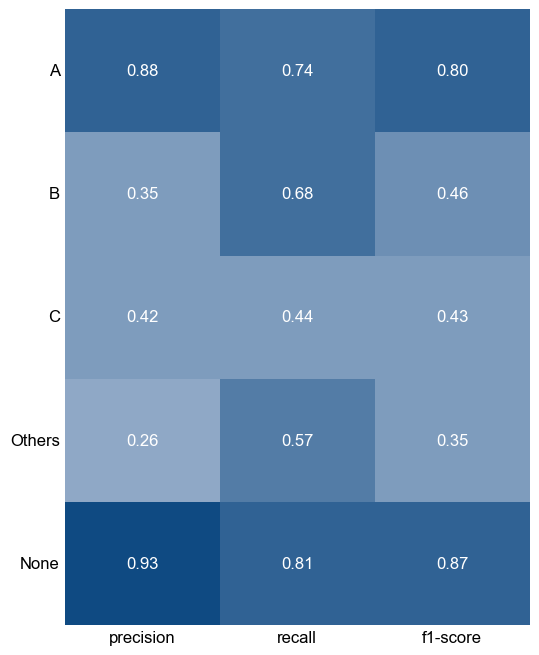

In [820]:
report_heatmap(report, 'plot05-01.png', custom_cmap_blues)

#### B. N-grams TF-IDF

In [840]:
dfm_train, dfm_test = get_dfm(ngram_vectorizer, train_df_aug, test_df)
train_text, train_labels, test_text, test_labels = dfm_train, train_df_aug['Category_New'], dfm_test, test_df['Category_New']

train dfm shape: (3445, 74265) | test dfm shape:(708, 74265)


In [841]:
sf_ngram, y_pred = softmax_train(train_text, train_labels, test_text, test_labels)

 Classification Report:
              precision    recall  f1-score   support

           A       0.90      0.63      0.74       376
           B       0.14      0.76      0.24        68
           C       0.46      0.33      0.39        18
        None       0.98      0.20      0.33       225
      Others       0.20      0.24      0.22        21

    accuracy                           0.49       708
   macro avg       0.54      0.43      0.38       708
weighted avg       0.82      0.49      0.54       708

Train vs Test Accuracy:
Train:0.959
Test:0.489


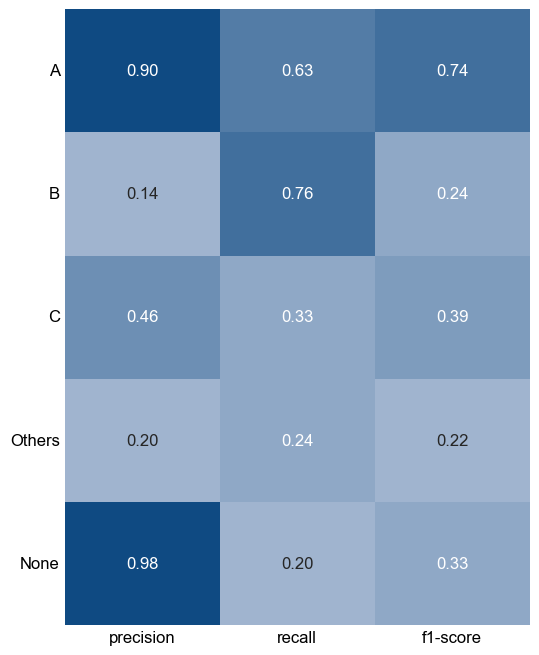

In [842]:
report = class_report_df(test_labels, y_pred)
report_heatmap(report, 'plot05-02.png', custom_cmap_blues)

In [843]:
feature_names, feature_importance = get_features(ngram_vectorizer, sf_ngram, 10)

Top 10 Important Bi-grams:
1. Features: performance guarantee, Importance: 1.6588598118453248
2. Features: partially international, Importance: 0.9084612484100452
3. Features: international set, Importance: 0.8261630049153988
4. Features: international standard, Importance: 0.8213533663797717
5. Features: expressly partially international, Importance: 0.7609556698270545
6. Features: expressly partially, Importance: 0.7609556698270545
7. Features: minimum capital, Importance: 0.7523470705719506
8. Features: approval anac, Importance: 0.7394080538273838
9. Features: pilotage zone, Importance: 0.7323799905655214
10. Features: sanitary registry, Importance: 0.7209519100879187


In [844]:
# get feature names from vocabulary of vectorizer
feature_names = ngram_vectorizer.get_feature_names_out()

# create a dataframe to store feature importance by category
df_feature_importance = pd.DataFrame(index=feature_names, columns=sf_ngram.classes_)

# iterate over each category and get feature importance
for i, category in enumerate(sf_ngram.classes_):
    importance = sf_ngram.coef_[i]
    feature_importance = abs(importance)
    sorted_idx = feature_importance.argsort()[::-1]
    
    # store feature importance in the dataframe
    for idx in sorted_idx:
        df_feature_importance.loc[feature_names[idx], category] = feature_importance[idx]
    
# fill missing values with 0
df_feature_importance = df_feature_importance.fillna(0)

# print the top 20 important features for each category
for category in sf_ngram.classes_:
    print(f'Top 10 Important Bi-grams for {category}:')
    print(df_feature_importance[category].sort_values(ascending=False).head(5))
    print('\n')

Top 10 Important Bi-grams for A:
performance guarantee      1.658860
partially international    0.908461
international set          0.826163
international standard     0.821353
expressly partially        0.760956
Name: A, dtype: float64


Top 10 Important Bi-grams for B:
price cap               1.658347
domestic market         1.422838
export market           1.337926
operational safety      1.254360
utical biotechnology    1.170514
Name: B, dtype: float64


Top 10 Important Bi-grams for C:
organizaciones ganaderas    2.136829
identification system       1.770641
registered anac             1.731525
except cefpp                1.586849
need registered             1.558747
Name: C, dtype: float64


Top 10 Important Bi-grams for None:
public private               1.166773
published dou                1.104068
go publication               1.044708
under term                   1.030597
airworthiness certificate    0.950183
Name: None, dtype: float64


Top 10 Important Bi-grams for Others:


In [845]:
# get the top 10 important features for each category
top_10_features = {}
for category in df_feature_importance.columns:
    top_10_features[category] = df_feature_importance.nlargest(20, category)[category]
    
# print the top 10 important features for each category
for category, feature_importance in top_10_features.items():
    print(f'Top 10 Important Bi-grams for {category}:')
    print(feature_importance)
    print('\n')

Top 10 Important Bi-grams for A:
performance guarantee                1.658860
partially international              0.908461
international set                    0.826163
international standard               0.821353
expressly partially                  0.760956
expressly partially international    0.760956
minimum capital                      0.752347
approval anac                        0.739408
pilotage zone                        0.732380
sanitary registry                    0.720952
value contract                       0.714811
reference medicine                   0.671048
flight attendant                     0.656789
international deal                   0.645460
registered reb                       0.644507
called linkage                       0.624895
orised school                        0.624895
prior approval anac                  0.614337
guarantee required                   0.613315
international standard deal          0.608821
Name: A, dtype: float64


Top 10 Important Bi-g

In [837]:
df_features = {}
for category in top_10_features:
    df_features[category] = pd.DataFrame(top_10_features[category])
    
    # add a column for the feature importance rank
    df_features[category]['Rank'] = range(1, 21)
    
    # rename the columns
    df_features[category].columns = ['Feature Importance', 'Rank']
    
    # reset the index
    df_features[category].reset_index(inplace=True)
    df_features[category].rename(columns={'index': 'Feature'}, inplace=True)

In [846]:
df_features_A = df_features['A'].drop(4, axis=0)
values_A = df_features_A[:10]['Feature Importance']
features_A = df_features_A[:10]['Feature']

df_features_B = df_features['B']
values_B = df_features_B[:10]['Feature Importance']
features_B = df_features_B[:10]['Feature']

df_features_C = df_features['C'].drop(0, axis=0)
word_count = df_features_C['Feature'].str.split().apply(len)  
df_features_C = df_features_C[word_count <= 3] # keep bi- and tri-grams
values_C = df_features_C[:10]['Feature Importance']
features_C = df_features_C[:10]['Feature']

df_features_D = df_features['Others']
values_D = df_features_D[:10]['Feature Importance']
features_D = df_features_D[:10]['Feature']

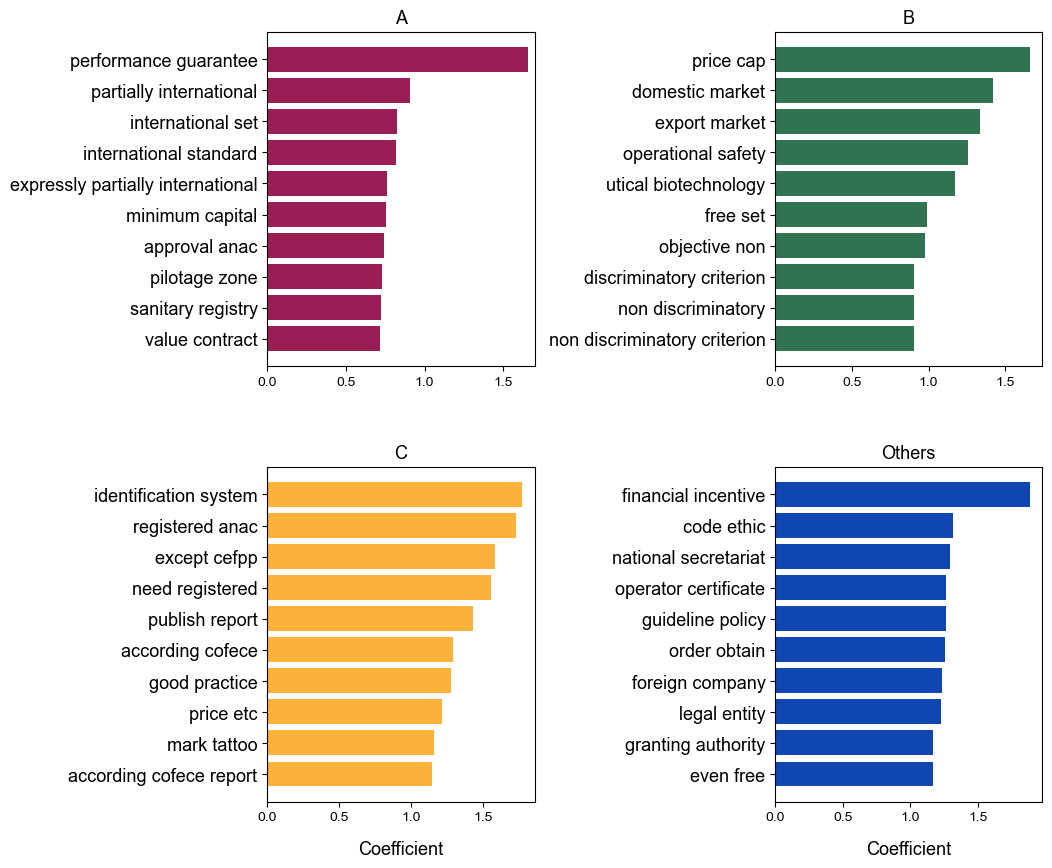

In [852]:
# create a 2x2 grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# plot the four bar charts in the subplots
axs[0, 0].barh(range(10), values_A, align='center', color='#991E56')
axs[0, 0].set_yticks(range(10))
axs[0, 0].set_yticklabels(features_A, fontname='Arial', fontsize=13)
#axs[0, 0].set_xlabel('Coefficient', labelpad=12, fontname='Arial', fontsize=13)
axs[0, 0].set_xticks([0, 0.5, 1, 1.5])
#axs[0, 0].set_xticklabels([0, 0.5, 1, 1.5], fontname='Arial', fontsize=12)
axs[0, 0].set_xlim(0, 1.7)
axs[0, 0].invert_yaxis()

axs[0, 1].barh(range(10), values_B, align='center', color='#307351')
axs[0, 1].set_yticks(range(10))
axs[0, 1].set_yticklabels(features_B, fontname='Arial', fontsize=13)
#axs[0, 1].set_xlabel('Coefficient', labelpad=12, fontname='Arial', fontsize=13)
axs[0, 0].set_xticks([0, 0.5, 1, 1.5])
#axs[0, 0].set_xticklabels([0, 0.5, 1, 1.5], fontname='Arial', fontsize=13)
axs[0, 0].set_xlim(0, 1.7)
axs[0, 1].invert_yaxis()

axs[1, 0].barh(range(10), values_C, align='center', color="#FCB13B")
axs[1, 0].set_yticks(range(10))
axs[1, 0].set_yticklabels(features_C, fontname='Arial', fontsize=13)
axs[1, 0].set_xlabel('Coefficient', labelpad=12, fontname='Arial', fontsize=13)
axs[0, 0].set_xticks([0, 0.5, 1, 1.5])
#axs[0, 0].set_xticklabels([0, 0.5, 1, 1.5], fontname='Arial', fontsize=13)
axs[0, 0].set_xlim(0, 1.7)
axs[1, 0].invert_yaxis()

axs[1, 1].barh(range(10), values_D, align='center', color='#1046b1')
axs[1, 1].set_yticks(range(10))
axs[1, 1].set_yticklabels(features_D, fontname='Arial', fontsize=13)
axs[1, 1].set_xlabel('Coefficient', labelpad=12, fontname='Arial', fontsize=13)
axs[0, 0].set_xticks([0, 0.5, 1, 1.5])
#axs[0, 0].set_xticklabels([0, 0.5, 1, 1.5], fontname='Arial', fontsize=13)
axs[0, 0].set_xlim(0, 1.7)
axs[1, 1].invert_yaxis()

axs[0, 0].set_title('A', fontname='Arial', fontsize=13)
axs[0, 1].set_title('B', fontname='Arial', fontsize=13)
axs[1, 0].set_title('C', fontname='Arial', fontsize=13)
axs[1, 1].set_title('Others', fontname='Arial', fontsize=13)

plt.subplots_adjust(wspace=0.9, hspace=0.3)

# save the figure
save_path = os.path.join('draft', 'images', 'plot05-03-combined.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')

# show the figure
plt.show()

In [ ]:
# function for learning curve
def plot_learning_curve(estimator, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.title('Learning Curve', fontname='Arial', fontsize=14)
    plt.xlabel('Training Examples', fontname= 'Arial', fontsize=12, labelpad=10)
    plt.ylabel('Accuracy', fontname='Arial', fontsize=12, labelpad=10)
    plt.xticks(fontname='Arial', fontsize=12)
    plt.yticks(fontname='Arial', fontsize=12)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='#C85B89',
             label='Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='#2A769E',
             label='Cross-validation Score')
    plt.legend(loc='best', prop={'family': 'Arial', 'size': 12})
    plt.show()

# plot learning curve
plot_learning_curve(sf, train_text_scaled, train_labels, cv=5)


### III. Logistic Regression with Word Embeddings

#### A. GloVe embeddings

Document embedding matrix

In [27]:
dims = 300
f = open(f'data/glove/glove.6B.{dims}d.txt') # download GloVe and save in data folder

embed_matrix = pd.read_table(
    f, sep = " ", index_col = 0, 
    header = None, quoting = csv.QUOTE_NONE
)

embed_matrix.shape

(400000, 300)

In [28]:
dfm_train, dfm_test = get_dfm(vectorizer, train_df_binary, test_df_binary)

train dfm shape: (3310, 5268) | test dfm shape:(613, 5268)


In [29]:
common_features = set(embed_matrix.index) & set(vectorizer.get_feature_names_out())
vocab_ids = [vectorizer.vocabulary_[x] for x in common_features]
len(common_features)

4665

In [29]:
# train dfm with embeddings
doc_matrix_train = dfm_train[:,vocab_ids].dot(embed_matrix.loc[common_features,])
doc_matrix_train.shape

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_18884/3073672550.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  doc_matrix_train = dfm_train[:,vocab_ids].dot(embed_matrix.loc[common_features,])


(3310, 300)

In [30]:
# test dfm with embeddings
doc_matrix_test = dfm_test[:,vocab_ids].dot(embed_matrix.loc[common_features,])
doc_matrix_test.shape

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_18884/3975398164.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  doc_matrix_test = dfm_test[:,vocab_ids].dot(embed_matrix.loc[common_features,])


(613, 300)

Train model

In [518]:
train_text, train_labels, test_text, test_labels = doc_matrix_train, train_df_binary['binary_label'], doc_matrix_test, test_df_binary['binary_label']

In [519]:
lg_glove, y_pred = logistic_train(train_text, train_labels, test_text, test_labels)

 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.62      0.71       221
           1       0.81      0.94      0.87       392

    accuracy                           0.82       613
   macro avg       0.83      0.78      0.79       613
weighted avg       0.83      0.82      0.81       613

Train vs Test Accuracy:
Train:0.942
Test:0.822


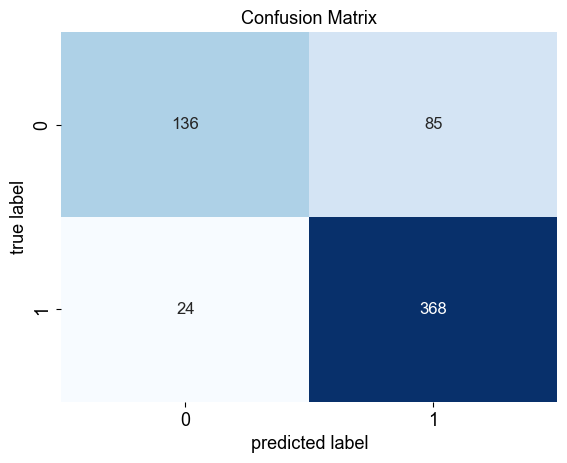

In [520]:
plot_cm(test_labels, y_pred, lg_glove)

#### B. Legalw2v embeddings

Document embedding matrix

In [30]:
w2v_law = KeyedVectors.load_word2vec_format("data/sigma-lemmatized-legal/legallemmatextreplacewithnnp.bin", binary=True, unicode_errors='ignore') 
w2v_law.vectors.shape

(52431, 200)

In [31]:
def doc_matrix_w2v(dfm):
    words = set(vectorizer.get_feature_names_out())
    text_vocab = list(words)

    common_features = []
    for word in text_vocab:
        if word in w2v_law:
            common_features += [word]

    embed_common=np.empty((0,200))
    for word in words:
        if word in w2v_law:
            embed_common=np.vstack([embed_common, w2v_law[word]])

    vocab_ids = [vectorizer.vocabulary_[x] for x in common_features]
    doc_matrix_w2v = dfm[:,vocab_ids].dot(embed_common)

    return doc_matrix_w2v
    

In [32]:
doc_matrix_train = doc_matrix_w2v(dfm_train)
doc_matrix_train.shape

(3310, 200)

In [33]:
doc_matrix_test = doc_matrix_w2v(dfm_test)
doc_matrix_test.shape

(613, 200)

Train model

In [535]:
train_text, train_labels, test_text, test_labels = doc_matrix_train, train_df_binary['binary_label'], doc_matrix_test, test_df_binary['binary_label']

In [536]:
lg_legal, y_pred = logistic_train(train_text, train_labels, test_text, test_labels)

 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.56      0.67       221
           1       0.79      0.94      0.86       392

    accuracy                           0.80       613
   macro avg       0.82      0.75      0.77       613
weighted avg       0.81      0.80      0.79       613

Train vs Test Accuracy:
Train:0.924
Test:0.804


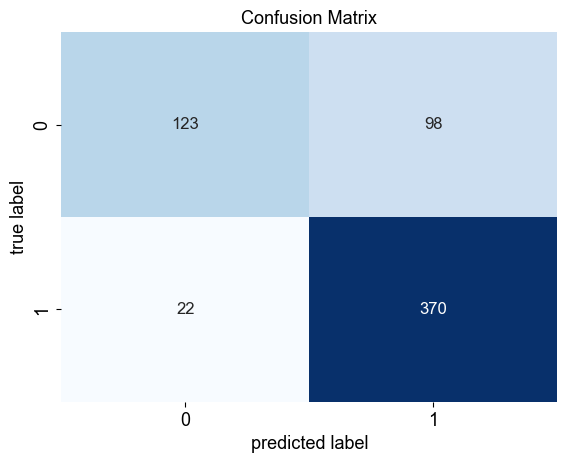

In [537]:
plot_cm(test_labels, y_pred, lg_legal)

### IV. Softmax Regression with Word Embeddings

#### A. GloVe

Document embedding matrix

In [853]:
dfm_train, dfm_test = get_dfm(vectorizer, train_df_aug, test_df)

train dfm shape: (3445, 5268) | test dfm shape:(708, 5268)


In [854]:
common_features = set(embed_matrix.index) & set(vectorizer.get_feature_names_out())
vocab_ids = [vectorizer.vocabulary_[x] for x in common_features]
len(common_features)

4665

In [858]:
doc_matrix_train = dfm_train[:,vocab_ids].dot(embed_matrix.loc[common_features,])
doc_matrix_test = dfm_test[:,vocab_ids].dot(embed_matrix.loc[common_features,])
print('train dfm shape: ' + str(doc_matrix_train.shape) + ' | test dfm shape: ' + str(doc_matrix_test.shape))

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_5629/2782685573.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  doc_matrix_train = dfm_train[:,vocab_ids].dot(embed_matrix.loc[common_features,])


train dfm shape: (3445, 300) | test dfm shape: (708, 300)


/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_5629/2782685573.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  doc_matrix_test = dfm_test[:,vocab_ids].dot(embed_matrix.loc[common_features,])


Train model

In [859]:
train_text, train_labels, test_text, test_labels = doc_matrix_train, train_df_aug['Category_New'], doc_matrix_test, test_df['Category_New']

In [860]:
sf_glove, y_pred = softmax_train(train_text, train_labels, test_text, test_labels)

 Classification Report:
              precision    recall  f1-score   support

           A       0.83      0.63      0.72       376
           B       0.29      0.63      0.40        68
           C       0.24      0.56      0.34        18
        None       0.82      0.63      0.71       225
      Others       0.14      0.38      0.20        21

    accuracy                           0.62       708
   macro avg       0.46      0.57      0.47       708
weighted avg       0.74      0.62      0.66       708

Train vs Test Accuracy:
Train:0.824
Test:0.623


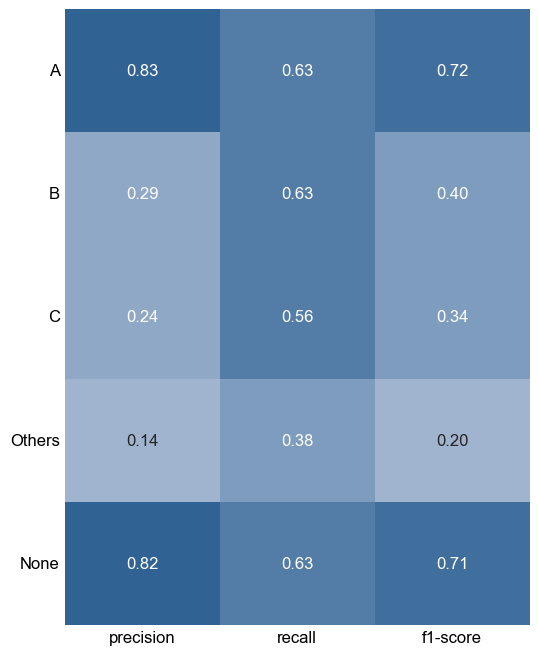

In [861]:
report = class_report_df(test_labels, y_pred)
report_heatmap(report, 'plot05-04.png', custom_cmap_blues)

#### B. Legalw2v

Document embedding matrix

In [862]:
doc_matrix_train = doc_matrix_w2v(dfm_train)
doc_matrix_test = doc_matrix_w2v(dfm_test)
print('train dfm shape: ' + str(doc_matrix_train.shape) + ' | test dfm shape: ' + str(doc_matrix_test.shape))

train dfm shape: (3445, 200) | test dfm shape: (708, 200)


Train model

In [863]:
train_text, train_labels, test_text, test_labels = doc_matrix_train, train_df_aug['Category_New'], doc_matrix_test, test_df['Category_New']

In [864]:
sf_legal, y_pred = softmax_train(train_text, train_labels, test_text, test_labels)

 Classification Report:
              precision    recall  f1-score   support

           A       0.83      0.57      0.68       376
           B       0.29      0.59      0.39        68
           C       0.16      0.50      0.24        18
        None       0.81      0.63      0.71       225
      Others       0.14      0.52      0.22        21

    accuracy                           0.59       708
   macro avg       0.45      0.56      0.45       708
weighted avg       0.74      0.59      0.64       708

Train vs Test Accuracy:
Train:0.765
Test:0.59


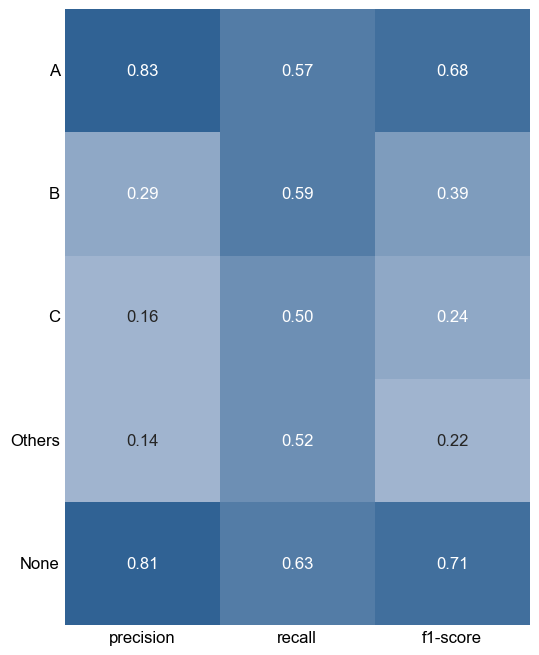

In [865]:
report = class_report_df(test_labels, y_pred)
report_heatmap(report, 'plot05-05.png', custom_cmap_blues)

### V. SVM

#### A. Binary TF-IDF uni-grams

Document feature matrix

In [722]:
dfm_train, dfm_test = get_dfm(vectorizer, train_df_binary, test_df_binary)

train dfm shape: (3310, 5268) | test dfm shape:(613, 5268)


Train model

In [719]:
train_text, train_labels, test_text, test_labels = dfm_train, train_df_binary['binary_label'], dfm_test, test_df_binary['binary_label']

In [717]:
def svm_train(train_text, train_labels, test_text, test_labels, model_name):
    scaler = StandardScaler(with_mean=False)
    train_text_scaled = scaler.fit_transform(train_text)
    test_text_scaled = scaler.transform(test_text)

    # train model and return training accuracy
    model = SVC(kernel='rbf', random_state=999, gamma='scale', C=1.0).fit(train_text_scaled, train_labels)
    with open('models/'+model_name+'.pkl', 'wb') as f: pickle.dump(model, f)

    train_acc = model.score(train_text_scaled, train_labels)

    # evaluate on test data 
    y_pred = model.predict(test_text_scaled)
    classification_rep = classification_report(test_labels, y_pred, zero_division=0)
    test_acc = model.score(test_text_scaled, test_labels)

    # print classification report
    print(' Classification Report:')
    print(classification_rep)
    print('Train vs Test Accuracy:')
    print('Train:' + str(round(train_acc, 3)))
    print('Test:' + str(round(test_acc, 3)))

    return model, y_pred

In [718]:
svm, y_pred = svm_train(train_text, train_labels, test_text, test_labels, 'svm')

 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.02      0.04       221
           1       0.64      1.00      0.78       392

    accuracy                           0.65       613
   macro avg       0.74      0.51      0.41       613
weighted avg       0.71      0.65      0.52       613

Train vs Test Accuracy:
Train:0.955
Test:0.646


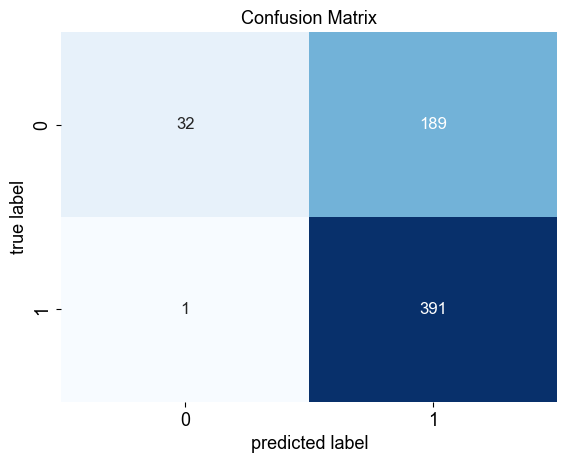

In [701]:
plot_cm(test_labels, y_pred, svm)

#### B. Binary TF-IDF n-grams

Document feature matrix

In [732]:
dfm_train, dfm_test = get_dfm(ngram_vectorizer, train_df_binary, test_df_binary)

train dfm shape: (3310, 74265) | test dfm shape:(613, 74265)


Train model

In [733]:
train_text, train_labels, test_text, test_labels = dfm_train, train_df_binary['binary_label'], dfm_test, test_df_binary['binary_label']

In [734]:
svm_ngrams, y_pred = svm_train(train_text, train_labels, test_text, test_labels, 'svm_ngrams')

 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.03      0.05       221
           1       0.65      1.00      0.78       392

    accuracy                           0.65       613
   macro avg       0.75      0.51      0.42       613
weighted avg       0.72      0.65      0.52       613

Train vs Test Accuracy:
Train:0.969
Test:0.648


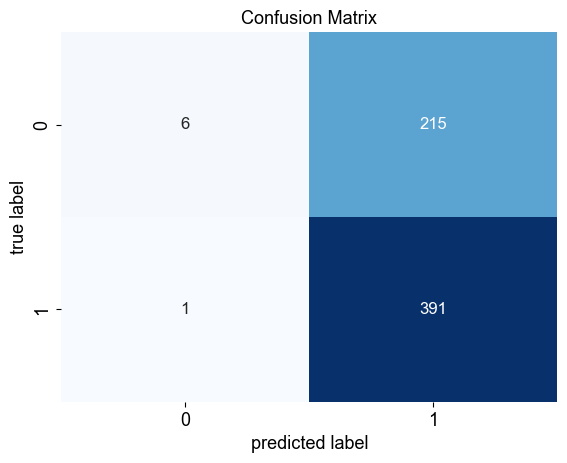

In [735]:
plot_cm(test_labels, y_pred, svm_ngrams)

#### C. Binary GloVe embeddings

Document embedding matrix

In [749]:
dfm_train, dfm_test = get_dfm(vectorizer, train_df_binary, test_df_binary)

train dfm shape: (3310, 5268) | test dfm shape:(613, 5268)


In [750]:
doc_matrix_train = dfm_train[:,vocab_ids].dot(embed_matrix.loc[common_features,])
doc_matrix_test = dfm_test[:,vocab_ids].dot(embed_matrix.loc[common_features,])

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_5629/2490878423.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  doc_matrix_train = dfm_train[:,vocab_ids].dot(embed_matrix.loc[common_features,])
/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_5629/2490878423.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  doc_matrix_test = dfm_test[:,vocab_ids].dot(embed_matrix.loc[common_features,])


Train model

In [751]:
train_text, train_labels, test_text, test_labels = doc_matrix_train, train_df_binary['binary_label'], doc_matrix_test, test_df_binary['binary_label']

In [752]:
svm_glove, y_pred = svm_train(train_text, train_labels, test_text, test_labels, 'svm_glove')

 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.54      0.69       221
           1       0.79      0.99      0.88       392

    accuracy                           0.83       613
   macro avg       0.88      0.76      0.79       613
weighted avg       0.86      0.83      0.81       613

Train vs Test Accuracy:
Train:0.969
Test:0.827


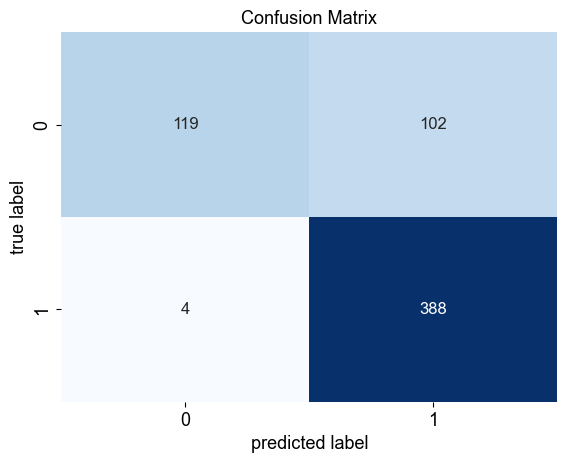

In [753]:
plot_cm(test_labels, y_pred, svm_glove)

#### D. Binary Legalw2v embeddings

Document embedding matrix

In [754]:
doc_matrix_train = doc_matrix_w2v(dfm_train)
doc_matrix_test = doc_matrix_w2v(dfm_test)

Train model

In [755]:
train_text, train_labels, test_text, test_labels = doc_matrix_train, train_df_binary['binary_label'], doc_matrix_test, test_df_binary['binary_label']

In [756]:
svm_legal, y_pred = svm_train(train_text, train_labels, test_text, test_labels, 'svm_legal')

 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.50      0.66       221
           1       0.78      0.99      0.87       392

    accuracy                           0.81       613
   macro avg       0.87      0.74      0.76       613
weighted avg       0.84      0.81      0.79       613

Train vs Test Accuracy:
Train:0.965
Test:0.812


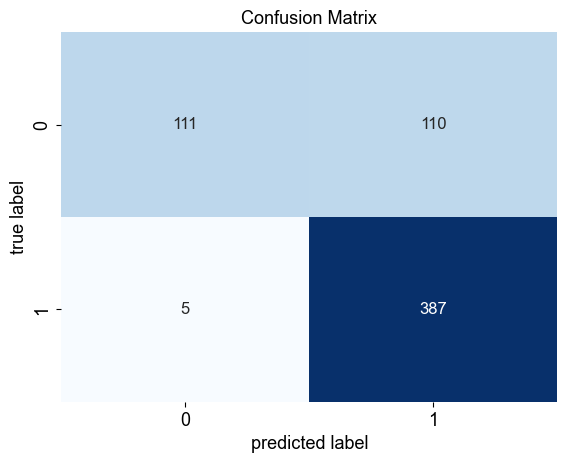

In [758]:
plot_cm(test_labels, y_pred, svm_legal)

#### E. Multiclass TF-IDF uni-grams

Document feature matrix

In [803]:
dfm_train, dfm_test = get_dfm(vectorizer, train_df_aug, test_df)

train dfm shape: (3445, 5268) | test dfm shape:(708, 5268)


Train model

In [804]:
train_text, train_labels, test_text, test_labels = dfm_train, train_df_aug['Category_New'], dfm_test, test_df['Category_New']

In [805]:
svm_multi, y_pred = svm_train(train_text, train_labels, test_text, test_labels, 'svm_multi')

 Classification Report:
              precision    recall  f1-score   support

           A       0.87      0.68      0.76       376
           B       0.27      0.60      0.38        68
           C       0.33      0.22      0.27        18
        None       0.76      0.74      0.75       225
      Others       0.18      0.29      0.22        21

    accuracy                           0.67       708
   macro avg       0.48      0.51      0.48       708
weighted avg       0.74      0.67      0.69       708

Train vs Test Accuracy:
Train:0.953
Test:0.668


Visualize results

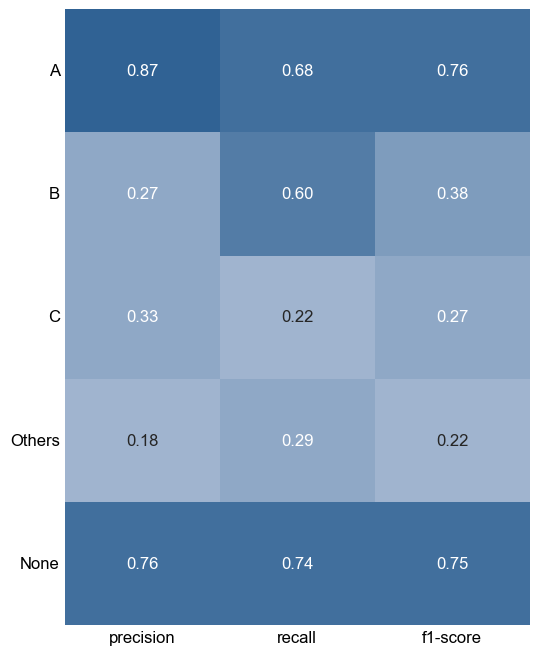

In [806]:
report = class_report_df(test_labels, y_pred)
report_heatmap(report, 'plot05-07.png', custom_cmap_blues)

#### F. Multiclass TF-IDF n-grams

Document feature matrix

In [807]:
dfm_train, dfm_test = get_dfm(ngram_vectorizer, train_df_aug, test_df)

train dfm shape: (3445, 74265) | test dfm shape:(708, 74265)


Train model

In [808]:
train_text, train_labels, test_text, test_labels = dfm_train, train_df_aug['Category_New'], dfm_test, test_df['Category_New']

In [809]:
svm_multi_ngram, y_pred = svm_train(train_text, train_labels, test_text, test_labels, 'svm_multi_ngram')

 Classification Report:
              precision    recall  f1-score   support

           A       0.90      0.48      0.63       376
           B       0.25      0.46      0.32        68
           C       0.05      0.94      0.09        18
        None       0.75      0.04      0.08       225
      Others       0.22      0.24      0.23        21

    accuracy                           0.34       708
   macro avg       0.43      0.43      0.27       708
weighted avg       0.75      0.34      0.40       708

Train vs Test Accuracy:
Train:0.923
Test:0.342


Visualize results

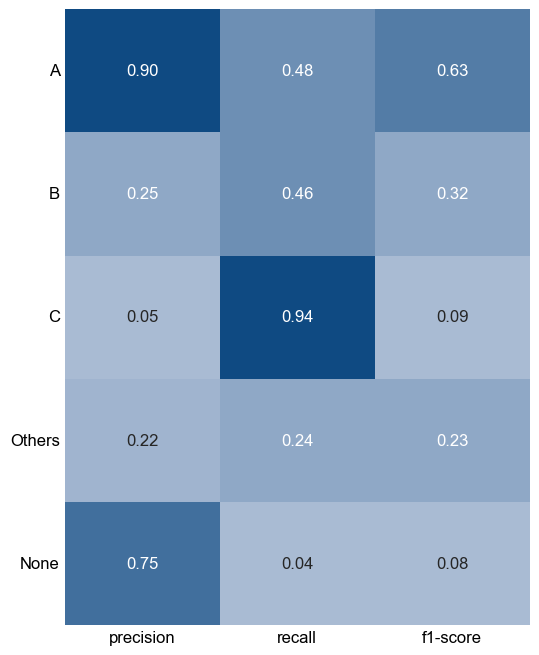

In [810]:
report = class_report_df(test_labels, y_pred)
report_heatmap(report, 'plot05-08.png', custom_cmap_blues)

#### G. Muliclass GloVe embeddings

Document embedding matrix

In [789]:
dfm_train, dfm_test = get_dfm(vectorizer, train_df_aug, test_df)

train dfm shape: (3445, 5268) | test dfm shape:(708, 5268)


In [790]:
doc_matrix_train = dfm_train[:,vocab_ids].dot(embed_matrix.loc[common_features,])
doc_matrix_test = dfm_test[:,vocab_ids].dot(embed_matrix.loc[common_features,])

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_5629/2490878423.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  doc_matrix_train = dfm_train[:,vocab_ids].dot(embed_matrix.loc[common_features,])
/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_5629/2490878423.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  doc_matrix_test = dfm_test[:,vocab_ids].dot(embed_matrix.loc[common_features,])


Train model

In [791]:
train_text, train_labels, test_text, test_labels = doc_matrix_train, train_df_aug['Category_New'], doc_matrix_test, test_df['Category_New']

In [792]:
svm_multi_glove, y_pred = svm_train(train_text, train_labels, test_text, test_labels, 'svm_multi_glove')

 Classification Report:
              precision    recall  f1-score   support

           A       0.84      0.70      0.77       376
           B       0.34      0.69      0.46        68
           C       0.27      0.44      0.33        18
        None       0.90      0.72      0.80       225
      Others       0.20      0.43      0.27        21

    accuracy                           0.69       708
   macro avg       0.51      0.60      0.52       708
weighted avg       0.78      0.69      0.72       708

Train vs Test Accuracy:
Train:0.912
Test:0.692


Visualize results

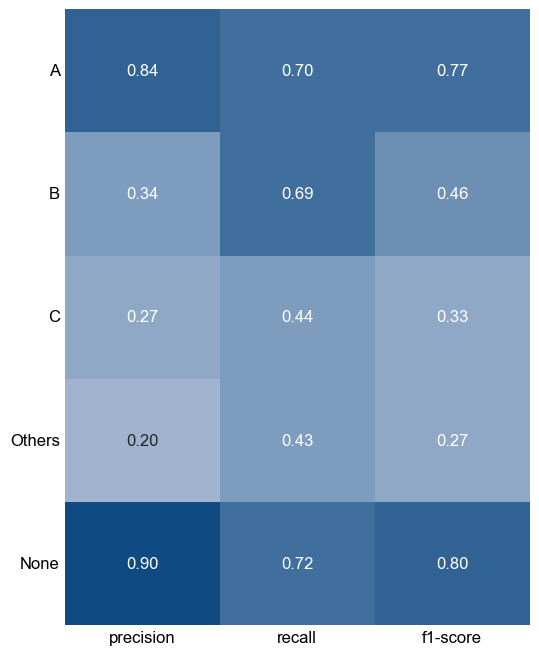

In [796]:
report = class_report_df(test_labels, y_pred)
report_heatmap(report, 'plot05-09.png', custom_cmap_blues)

#### H. Multiclass Legalw2v embeddings

Document embedding matrix

In [798]:
doc_matrix_train = doc_matrix_w2v(dfm_train)
doc_matrix_test = doc_matrix_w2v(dfm_test)

Train model

In [799]:
train_text, train_labels, test_text, test_labels = doc_matrix_train, train_df_aug['Category_New'], doc_matrix_test, test_df['Category_New']

In [800]:
svm_multi_legal, y_pred = svm_train(train_text, train_labels, test_text, test_labels, 'svm_multi_legal')

 Classification Report:
              precision    recall  f1-score   support

           A       0.86      0.72      0.79       376
           B       0.34      0.68      0.45        68
           C       0.24      0.50      0.33        18
        None       0.90      0.72      0.80       225
      Others       0.23      0.43      0.30        21

    accuracy                           0.70       708
   macro avg       0.51      0.61      0.53       708
weighted avg       0.79      0.70      0.73       708

Train vs Test Accuracy:
Train:0.918
Test:0.703


Visualize results

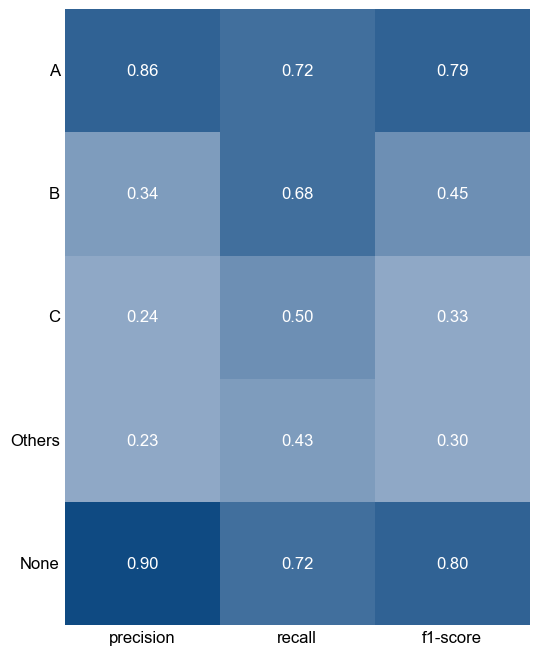

In [801]:
report = class_report_df(test_labels, y_pred)
report_heatmap(report, 'plot05-10.png', custom_cmap_blues)

### VI. SVM Hyperparameter Tuning

In [892]:
# define hyperparameters
parameters = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf'],
              'decision_function_shape': ['ovo', 'ovr']}

In [899]:
# k-fold validation 
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=999)

#### A. Multiclass TF-IDF uni-grams

In [900]:
dfm_train, dfm_test = get_dfm(vectorizer, train_df_aug, test_df)

train dfm shape: (3445, 5268) | test dfm shape:(708, 5268)


In [901]:
train_text, train_labels, test_text, test_labels = dfm_train, train_df_aug['Category_New'], dfm_test, test_df['Category_New']

In [902]:
grid_multi_uni = GridSearchCV(SVC(), parameters, refit = True, verbose = 3, cv=cv)
grid_multi_uni.fit(train_text, train_labels)

Fitting 15 folds for each of 40 candidates, totalling 600 fits
[CV 1/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.321 total time=   2.0s
[CV 2/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.331 total time=   2.1s
[CV 3/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.380 total time=   2.1s
[CV 4/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.356 total time=   2.0s
[CV 5/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.337 total time=   2.2s
[CV 6/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.367 total time=   2.1s
[CV 7/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.341 total time=   2.0s
[CV 8/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.338 total time=   2.0s
[CV 9/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.335 total time=   2.1s
[CV 10/15]

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']},
             verbose=3)

In [903]:
print(grid_multi_uni.best_params_)

{'C': 1, 'decision_function_shape': 'ovo', 'gamma': 1, 'kernel': 'rbf'}


In [904]:
grid_predictions = grid_multi_uni.predict(test_text)
print(classification_report(test_labels, grid_predictions))

              precision    recall  f1-score   support

           A       0.86      0.80      0.83       376
           B       0.37      0.59      0.45        68
           C       0.40      0.33      0.36        18
        None       0.93      0.85      0.89       225
      Others       0.25      0.33      0.29        21

    accuracy                           0.77       708
   macro avg       0.56      0.58      0.56       708
weighted avg       0.80      0.77      0.78       708



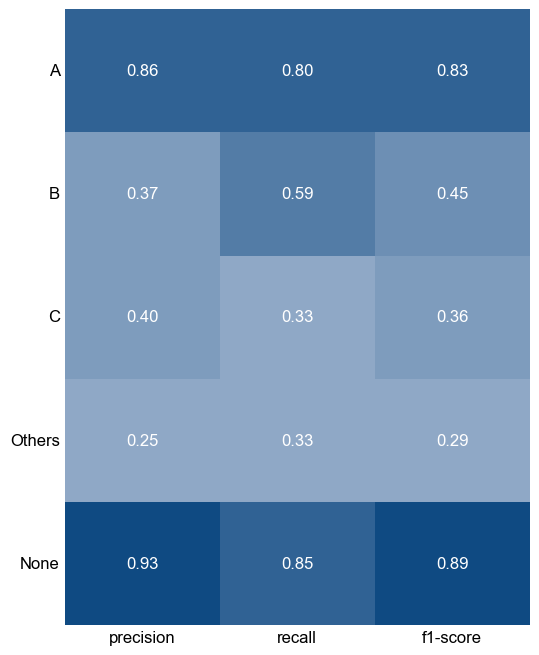

In [905]:
report = class_report_df(test_labels, grid_predictions)
report_heatmap(report, 'plot05-11.png', custom_cmap_blues)

#### B. Multiclass TF-IDF n-grams

In [906]:
dfm_train, dfm_test = get_dfm(ngram_vectorizer, train_df_aug, test_df)
train_text, train_labels, test_text, test_labels = dfm_train, train_df_aug['Category_New'], dfm_test, test_df['Category_New']

train dfm shape: (3445, 74265) | test dfm shape:(708, 74265)


In [907]:
grid_multi_ngram = GridSearchCV(SVC(), parameters, refit = True, verbose = 3, cv=cv)
grid_multi_ngram.fit(train_text, train_labels)

Fitting 15 folds for each of 40 candidates, totalling 600 fits
[CV 1/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.242 total time=   2.4s
[CV 2/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.255 total time=   2.3s
[CV 3/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.283 total time=   2.3s
[CV 4/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.269 total time=   2.2s
[CV 5/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.248 total time=   2.2s
[CV 6/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.270 total time=   2.2s
[CV 7/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.258 total time=   2.2s
[CV 8/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.253 total time=   2.2s
[CV 9/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.254 total time=   2.2s
[CV 10/15]

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']},
             verbose=3)

In [908]:
print(grid_multi_ngram.best_params_)

{'C': 1000, 'decision_function_shape': 'ovo', 'gamma': 0.001, 'kernel': 'rbf'}


In [909]:
grid_predictions = grid_multi_ngram.predict(test_text)
print(classification_report(test_labels, grid_predictions))

              precision    recall  f1-score   support

           A       0.84      0.81      0.83       376
           B       0.35      0.66      0.46        68
           C       0.46      0.33      0.39        18
        None       0.97      0.77      0.86       225
      Others       0.21      0.24      0.22        21

    accuracy                           0.76       708
   macro avg       0.57      0.56      0.55       708
weighted avg       0.81      0.76      0.77       708



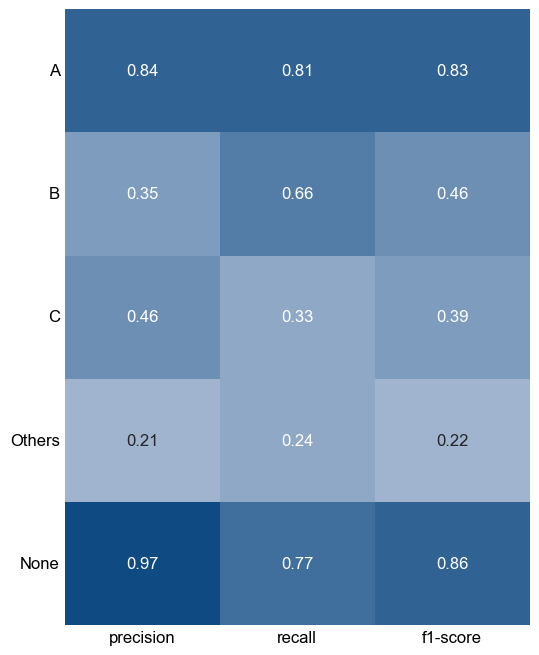

In [910]:
report = class_report_df(test_labels, grid_predictions)
report_heatmap(report, 'plot05-12.png', custom_cmap_blues)

#### C. Multiclass GloVe embeddings

In [911]:
dfm_train, dfm_test = get_dfm(vectorizer, train_df_aug, test_df)
doc_matrix_train = dfm_train[:,vocab_ids].dot(embed_matrix.loc[common_features,])
doc_matrix_test = dfm_test[:,vocab_ids].dot(embed_matrix.loc[common_features,])

train dfm shape: (3445, 5268) | test dfm shape:(708, 5268)


/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_5629/3399062756.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  doc_matrix_train = dfm_train[:,vocab_ids].dot(embed_matrix.loc[common_features,])
/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_5629/3399062756.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  doc_matrix_test = dfm_test[:,vocab_ids].dot(embed_matrix.loc[common_features,])


In [912]:
train_text, train_labels, test_text, test_labels = doc_matrix_train, train_df_aug['Category_New'], doc_matrix_test, test_df['Category_New']

In [913]:
grid_multi_glove = GridSearchCV(SVC(), parameters, refit = True, verbose = 3, cv=cv)
grid_multi_glove.fit(train_text, train_labels)

Fitting 15 folds for each of 40 candidates, totalling 600 fits
[CV 1/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.244 total time=   2.2s
[CV 2/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.255 total time=   2.2s
[CV 3/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.283 total time=   2.1s
[CV 4/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.269 total time=   2.2s
[CV 5/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.248 total time=   2.1s
[CV 6/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.270 total time=   2.1s
[CV 7/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.258 total time=   2.1s
[CV 8/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.253 total time=   2.1s
[CV 9/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.257 total time=   2.1s
[CV 10/15]

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']},
             verbose=3)

In [914]:
print(grid_multi_glove.best_params_)

{'C': 10, 'decision_function_shape': 'ovo', 'gamma': 0.01, 'kernel': 'rbf'}


In [915]:
grid_predictions = grid_multi_glove.predict(test_text)
print(classification_report(test_labels, grid_predictions))

              precision    recall  f1-score   support

           A       0.83      0.80      0.82       376
           B       0.38      0.54      0.45        68
           C       0.31      0.50      0.38        18
        None       0.92      0.76      0.84       225
      Others       0.21      0.33      0.26        21

    accuracy                           0.74       708
   macro avg       0.53      0.59      0.55       708
weighted avg       0.79      0.74      0.76       708



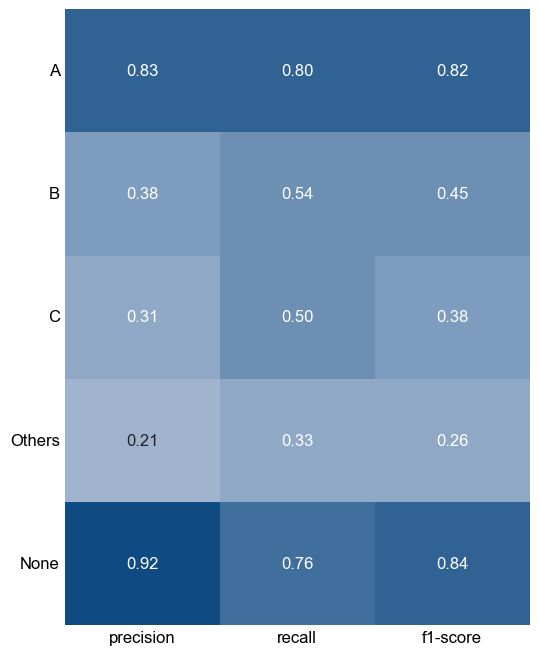

In [916]:
report = class_report_df(test_labels, grid_predictions)
report_heatmap(report, 'plot05-13.png', custom_cmap_blues)

#### D. Multiclass Legalw2v embeddings

In [917]:
doc_matrix_train = doc_matrix_w2v(dfm_train)
doc_matrix_test = doc_matrix_w2v(dfm_test)

In [918]:
train_text, train_labels, test_text, test_labels = doc_matrix_train, train_df_aug['Category_New'], doc_matrix_test, test_df['Category_New']

In [919]:
grid_multi_legal = GridSearchCV(SVC(), parameters, refit = True, verbose = 3, cv=cv)
grid_multi_legal.fit(train_text, train_labels)

Fitting 15 folds for each of 40 candidates, totalling 600 fits
[CV 1/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.244 total time=   1.3s
[CV 2/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.255 total time=   1.3s
[CV 3/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.283 total time=   1.3s
[CV 4/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.269 total time=   1.3s
[CV 5/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.248 total time=   1.3s
[CV 6/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.270 total time=   1.3s
[CV 7/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.258 total time=   1.3s
[CV 8/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.253 total time=   1.3s
[CV 9/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.257 total time=   1.3s
[CV 10/15]

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']},
             verbose=3)

In [920]:
print(grid_multi_legal.best_params_)

{'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.001, 'kernel': 'rbf'}


In [921]:
grid_predictions = grid_multi_legal.predict(test_text)
print(classification_report(test_labels, grid_predictions))

              precision    recall  f1-score   support

           A       0.86      0.76      0.80       376
           B       0.35      0.68      0.46        68
           C       0.24      0.44      0.31        18
        None       0.92      0.72      0.81       225
      Others       0.25      0.43      0.32        21

    accuracy                           0.72       708
   macro avg       0.52      0.60      0.54       708
weighted avg       0.79      0.72      0.74       708



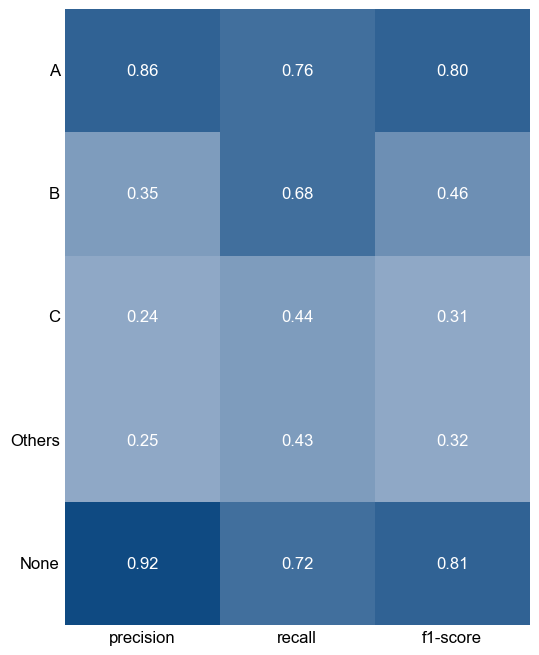

In [922]:
report = class_report_df(test_labels, grid_predictions)
report_heatmap(report, 'plot05-14.png', custom_cmap_blues)

#### E. Binary TF-IDF uni-grams

In [925]:
dfm_train, dfm_test = get_dfm(vectorizer, train_df_binary, test_df_binary)
train_text, train_labels, test_text, test_labels = dfm_train, train_df_binary['binary_label'], dfm_test, test_df_binary['binary_label']

train dfm shape: (3310, 5268) | test dfm shape:(613, 5268)


In [926]:
grid_bin_uni = GridSearchCV(SVC(), parameters, refit = True, verbose = 3, cv=cv)
grid_bin_uni.fit(train_text, train_labels)

Fitting 15 folds for each of 40 candidates, totalling 600 fits
[CV 1/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.847 total time=   1.0s
[CV 2/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.805 total time=   0.9s
[CV 3/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.843 total time=   0.9s
[CV 4/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.872 total time=   1.0s
[CV 5/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.846 total time=   0.9s
[CV 6/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.826 total time=   0.9s
[CV 7/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.869 total time=   1.0s
[CV 8/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.843 total time=   1.0s
[CV 9/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.823 total time=   0.9s
[CV 10/15]

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']},
             verbose=3)

In [930]:
print(grid_bin_uni.best_params_)
best_model = grid_bin_uni.best_estimator_

{'C': 10, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'kernel': 'rbf'}


In [931]:
grid_predictions = grid_bin_uni.predict(test_text)
print(classification_report(test_labels, grid_predictions))

              precision    recall  f1-score   support

           0       0.95      0.75      0.84       221
           1       0.87      0.98      0.92       392

    accuracy                           0.90       613
   macro avg       0.91      0.86      0.88       613
weighted avg       0.90      0.90      0.89       613



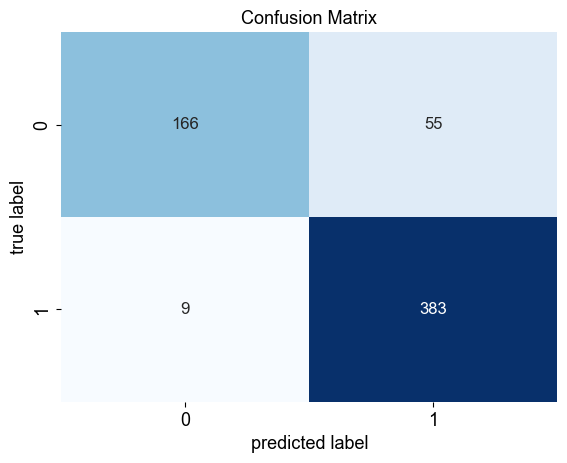

In [933]:
plot_cm(test_labels, grid_predictions, best_model)

#### F. Binary TF-IDF n-grams

In [941]:
dfm_train, dfm_test = get_dfm(ngram_vectorizer, train_df_binary, test_df_binary)
train_text, train_labels, test_text, test_labels = dfm_train, train_df_binary['binary_label'], dfm_test, test_df_binary['binary_label']

train dfm shape: (3310, 74265) | test dfm shape:(613, 74265)


In [935]:
grid_bin_ngram = GridSearchCV(SVC(), parameters, refit = True, verbose = 3, cv=cv)
grid_bin_ngram.fit(train_text, train_labels)

Fitting 15 folds for each of 40 candidates, totalling 600 fits
[CV 1/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.847 total time=   2.1s
[CV 2/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.805 total time=   2.4s
[CV 3/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.843 total time=   2.1s
[CV 4/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.872 total time=   2.1s
[CV 5/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.846 total time=   2.1s
[CV 6/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.826 total time=   2.2s
[CV 7/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.869 total time=   2.2s
[CV 8/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.843 total time=   2.1s
[CV 9/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.823 total time=   2.3s
[CV 10/15]

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']},
             verbose=3)

In [942]:
print(grid_bin_ngram.best_params_)
best_model = grid_bin_ngram.best_estimator_

{'C': 1000, 'decision_function_shape': 'ovo', 'gamma': 0.001, 'kernel': 'rbf'}


In [943]:
grid_predictions = grid_bin_ngram.predict(test_text)
print(classification_report(test_labels, grid_predictions))

              precision    recall  f1-score   support

           0       0.97      0.16      0.28       221
           1       0.68      1.00      0.81       392

    accuracy                           0.70       613
   macro avg       0.83      0.58      0.54       613
weighted avg       0.78      0.70      0.62       613



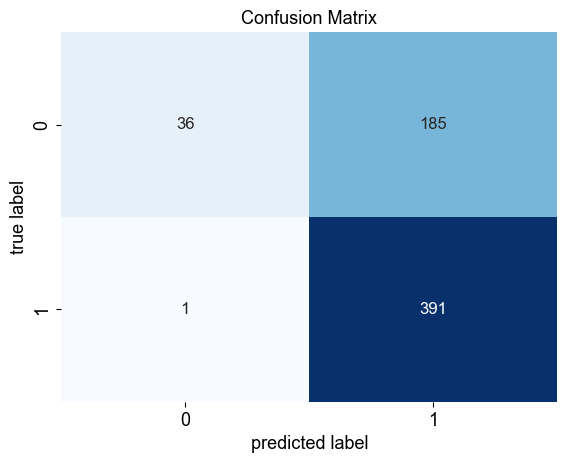

In [944]:
plot_cm(test_labels, grid_predictions, best_model)

#### G. Binary GloVe embeddings

In [945]:
dfm_train, dfm_test = get_dfm(vectorizer, train_df_binary, test_df_binary)
doc_matrix_train = dfm_train[:,vocab_ids].dot(embed_matrix.loc[common_features,])
doc_matrix_test = dfm_test[:,vocab_ids].dot(embed_matrix.loc[common_features,])

train dfm shape: (3310, 5268) | test dfm shape:(613, 5268)


/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_5629/3597952091.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  doc_matrix_train = dfm_train[:,vocab_ids].dot(embed_matrix.loc[common_features,])
/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_5629/3597952091.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  doc_matrix_test = dfm_test[:,vocab_ids].dot(embed_matrix.loc[common_features,])


In [946]:
train_text, train_labels, test_text, test_labels = doc_matrix_train, train_df_binary['binary_label'], doc_matrix_test, test_df_binary['binary_label']

In [947]:
grid_bin_glove = GridSearchCV(SVC(), parameters, refit = True, verbose = 3, cv=cv)
grid_bin_glove.fit(train_text, train_labels)

Fitting 15 folds for each of 40 candidates, totalling 600 fits
[CV 1/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.847 total time=   2.3s
[CV 2/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.805 total time=   2.1s
[CV 3/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.843 total time=   2.1s
[CV 4/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.872 total time=   2.2s
[CV 5/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.846 total time=   2.3s
[CV 6/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.826 total time=   2.0s
[CV 7/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.869 total time=   2.3s
[CV 8/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.843 total time=   2.1s
[CV 9/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.823 total time=   2.2s
[CV 10/15]

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']},
             verbose=3)

In [948]:
print(grid_bin_glove.best_params_)
best_model = grid_bin_glove.best_estimator_

{'C': 10, 'decision_function_shape': 'ovo', 'gamma': 0.01, 'kernel': 'rbf'}


In [949]:
grid_predictions = grid_bin_glove.predict(test_text)
print(classification_report(test_labels, grid_predictions))

              precision    recall  f1-score   support

           0       0.93      0.67      0.78       221
           1       0.84      0.97      0.90       392

    accuracy                           0.86       613
   macro avg       0.89      0.82      0.84       613
weighted avg       0.87      0.86      0.86       613



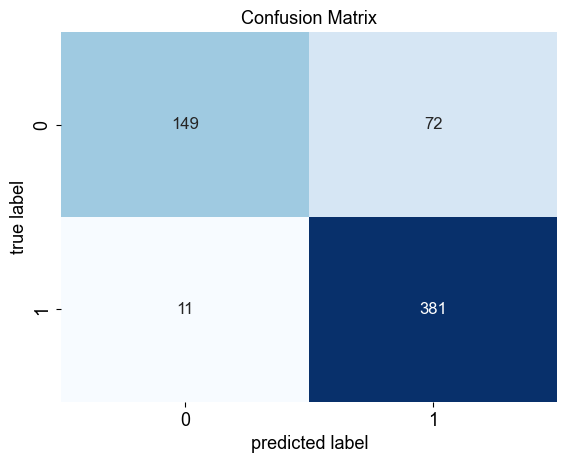

In [950]:
plot_cm(test_labels, grid_predictions, best_model)

#### H. Binary Legalw2v embeddings

In [951]:
doc_matrix_train = doc_matrix_w2v(dfm_train)
doc_matrix_test = doc_matrix_w2v(dfm_test)

train_text, train_labels, test_text, test_labels = doc_matrix_train, train_df_binary['binary_label'], doc_matrix_test, test_df_binary['binary_label']

In [952]:
grid_bin_legal = GridSearchCV(SVC(), parameters, refit = True, verbose = 3, cv=cv)
grid_bin_legal.fit(train_text, train_labels)

Fitting 15 folds for each of 40 candidates, totalling 600 fits
[CV 1/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.847 total time=   1.3s
[CV 2/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.805 total time=   1.3s
[CV 3/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.843 total time=   1.3s
[CV 4/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.872 total time=   1.3s
[CV 5/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.846 total time=   1.3s
[CV 6/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.826 total time=   1.3s
[CV 7/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.869 total time=   1.3s
[CV 8/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.843 total time=   1.3s
[CV 9/15] END C=0.1, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.823 total time=   1.3s
[CV 10/15]

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']},
             verbose=3)

In [953]:
print(grid_bin_legal.best_params_)
best_model = grid_bin_legal.best_estimator_

{'C': 10, 'decision_function_shape': 'ovo', 'gamma': 0.001, 'kernel': 'rbf'}


In [954]:
grid_predictions = grid_bin_legal.predict(test_text)
print(classification_report(test_labels, grid_predictions))

              precision    recall  f1-score   support

           0       0.93      0.65      0.77       221
           1       0.83      0.97      0.90       392

    accuracy                           0.86       613
   macro avg       0.88      0.81      0.83       613
weighted avg       0.87      0.86      0.85       613



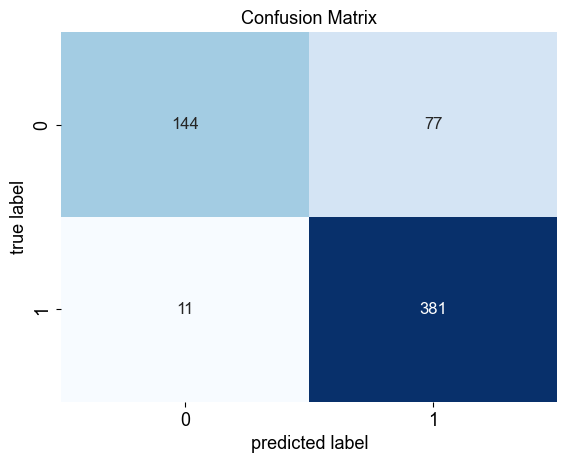

In [955]:
plot_cm(test_labels, grid_predictions, best_model)

### VII. Logistic Hyperparameter Tuning

In [34]:
# define hyperparameters
parameters = {'C': [0.1, 1, 10, 100, 1000], 
              'penalty':  ['l1', 'l2', 'None'],
              'solver': ['liblinear', 'lbfgs']}

# k-fold validation 
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=999)

#### A. TF-IDF uni-grams

In [35]:
dfm_train, dfm_test = get_dfm(vectorizer, train_df_binary, test_df_binary)
train_text, train_labels, test_text, test_labels = dfm_train, train_df_binary['binary_label'], dfm_test, test_df_binary['binary_label']

train dfm shape: (3310, 5268) | test dfm shape:(613, 5268)


In [36]:
lg_grid_bin_uni = GridSearchCV(LogisticRegression(random_state=999, max_iter=1000), parameters, refit = True, verbose = 3, cv=cv)
lg_grid_bin_uni.fit(train_text, train_labels)

Fitting 15 folds for each of 45 candidates, totalling 675 fits
[CV 1/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.847 total time=   0.0s
[CV 2/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.805 total time=   0.0s
[CV 3/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.843 total time=   0.0s
[CV 4/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.872 total time=   0.0s
[CV 5/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.846 total time=   0.0s
[CV 6/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.826 total time=   0.0s
[CV 7/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.869 total time=   0.0s
[CV 8/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.843 total time=   0.0s
[CV 9/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.823 total time=   0.0s
[CV 10/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.852 total time=   0.0s
[CV 11/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.826 total time=   0.0s
[CV 12/15] END C=0.1, 

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/15] END C=10, penalty=l1, solver=liblinear;, score=0.924 total time=  50.3s
[CV 2/15] END C=10, penalty=l1, solver=liblinear;, score=0.932 total time=   0.0s
[CV 3/15] END C=10, penalty=l1, solver=liblinear;, score=0.944 total time=   0.0s
[CV 4/15] END C=10, penalty=l1, solver=liblinear;, score=0.940 total time=   0.0s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/15] END C=10, penalty=l1, solver=liblinear;, score=0.929 total time=  46.3s
[CV 6/15] END C=10, penalty=l1, solver=liblinear;, score=0.917 total time=   0.0s
[CV 7/15] END C=10, penalty=l1, solver=liblinear;, score=0.943 total time=   0.0s
[CV 8/15] END C=10, penalty=l1, solver=liblinear;, score=0.932 total time=   0.0s
[CV 9/15] END C=10, penalty=l1, solver=liblinear;, score=0.918 total time=   0.0s
[CV 10/15] END C=10, penalty=l1, solver=liblinear;, score=0.946 total time=   0.0s
[CV 11/15] END C=10, penalty=l1, solver=liblinear;, score=0.917 total time=   0.0s
[CV 12/15] END C=10, penalty=l1, solver=liblinear;, score=0.927 total time=   0.0s
[CV 13/15] END C=10, penalty=l1, solver=liblinear;, score=0.924 total time=   0.0s
[CV 14/15] END C=10, penalty=l1, solver=liblinear;, score=0.940 total time=   0.0s
[CV 15/15] END C=10, penalty=l1, solver=liblinear;, score=0.943 total time=   0.0s
[CV 1/15] END .....C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/15] E

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/15] END ....C=10, penalty=l1, solver=saga;, score=0.924 total time=   8.0s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/15] END ....C=10, penalty=l1, solver=saga;, score=0.932 total time=   7.7s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/15] END ....C=10, penalty=l1, solver=saga;, score=0.944 total time=   8.0s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/15] END ....C=10, penalty=l1, solver=saga;, score=0.938 total time=   8.2s
[CV 5/15] END ....C=10, penalty=l1, solver=saga;, score=0.929 total time=   7.1s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/15] END ....C=10, penalty=l1, solver=saga;, score=0.917 total time=   7.6s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/15] END ....C=10, penalty=l1, solver=saga;, score=0.943 total time=   8.1s
[CV 8/15] END ....C=10, penalty=l1, solver=saga;, score=0.932 total time=   7.1s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/15] END ....C=10, penalty=l1, solver=saga;, score=0.920 total time=   4.5s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/15] END ...C=10, penalty=l1, solver=saga;, score=0.946 total time=   4.9s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 11/15] END ...C=10, penalty=l1, solver=saga;, score=0.917 total time=   4.8s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 12/15] END ...C=10, penalty=l1, solver=saga;, score=0.929 total time=   4.8s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 13/15] END ...C=10, penalty=l1, solver=saga;, score=0.924 total time=   4.8s
[CV 14/15] END ...C=10, penalty=l1, solver=saga;, score=0.941 total time=   4.8s
[CV 15/15] END ...C=10, penalty=l1, solver=saga;, score=0.943 total time=   4.1s
[CV 1/15] END C=10, penalty=l2, solver=liblinear;, score=0.917 total time=   0.0s
[CV 2/15] END C=10, penalty=l2, solver=liblinear;, score=0.926 total time=   0.0s
[CV 3/15] END C=10, penalty=l2, solver=liblinear;, score=0.949 total time=   0.0s
[CV 4/15] END C=10, penalty=l2, solver=liblinear;, score=0.947 total time=   0.0s
[CV 5/15] END C=10, penalty=l2, solver=liblinear;, score=0.918 total time=   0.0s
[CV 6/15] END C=10, penalty=l2, solver=liblinear;, score=0.911 total time=   0.0s
[CV 7/15] END C=10, penalty=l2, solver=liblinear;, score=0.953 total time=   0.0s
[CV 8/15] END C=10, penalty=l2, solver=liblinear;, score=0.926 total time=   0.0s
[CV 9/15] END C=10, penalty=l2, solver=liblinear;, score=0.924 total time=   0.0s
[CV 10/15] END C=10

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/15] END ...C=100, penalty=l1, solver=saga;, score=0.935 total time=  11.8s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/15] END ...C=100, penalty=l1, solver=saga;, score=0.941 total time=  11.9s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/15] END ...C=100, penalty=l1, solver=saga;, score=0.952 total time=  12.5s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/15] END ...C=100, penalty=l1, solver=saga;, score=0.943 total time=  12.0s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/15] END ...C=100, penalty=l1, solver=saga;, score=0.938 total time=  11.6s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/15] END ...C=100, penalty=l1, solver=saga;, score=0.929 total time=  11.4s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/15] END ...C=100, penalty=l1, solver=saga;, score=0.949 total time=  12.1s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/15] END ...C=100, penalty=l1, solver=saga;, score=0.924 total time=  12.3s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/15] END ...C=100, penalty=l1, solver=saga;, score=0.934 total time=  11.5s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/15] END ..C=100, penalty=l1, solver=saga;, score=0.949 total time=  12.2s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 11/15] END ..C=100, penalty=l1, solver=saga;, score=0.924 total time=  11.1s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 12/15] END ..C=100, penalty=l1, solver=saga;, score=0.940 total time=  11.8s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 13/15] END ..C=100, penalty=l1, solver=saga;, score=0.932 total time=  12.4s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 14/15] END ..C=100, penalty=l1, solver=saga;, score=0.955 total time=  12.2s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 15/15] END ..C=100, penalty=l1, solver=saga;, score=0.938 total time=  12.2s
[CV 1/15] END C=100, penalty=l2, solver=liblinear;, score=0.932 total time=   0.0s
[CV 2/15] END C=100, penalty=l2, solver=liblinear;, score=0.943 total time=   0.0s
[CV 3/15] END C=100, penalty=l2, solver=liblinear;, score=0.961 total time=   0.0s
[CV 4/15] END C=100, penalty=l2, solver=liblinear;, score=0.950 total time=   0.0s
[CV 5/15] END C=100, penalty=l2, solver=liblinear;, score=0.937 total time=   0.0s
[CV 6/15] END C=100, penalty=l2, solver=liblinear;, score=0.931 total time=   0.0s
[CV 7/15] END C=100, penalty=l2, solver=liblinear;, score=0.953 total time=   0.0s
[CV 8/15] END C=100, penalty=l2, solver=liblinear;, score=0.934 total time=   0.0s
[CV 9/15] END C=100, penalty=l2, solver=liblinear;, score=0.932 total time=   0.0s
[CV 10/15] END C=100, penalty=l2, solver=liblinear;, score=0.950 total time=   0.0s
[CV 11/15] END C=100, penalty=l2, solver=liblinear;, score=0.929 total time=   0.0s
[CV 

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/15] END ..C=1000, penalty=l1, solver=saga;, score=0.938 total time=  33.3s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/15] END ..C=1000, penalty=l1, solver=saga;, score=0.935 total time=  33.5s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/15] END ..C=1000, penalty=l1, solver=saga;, score=0.959 total time=  33.6s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/15] END ..C=1000, penalty=l1, solver=saga;, score=0.949 total time=  34.5s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/15] END ..C=1000, penalty=l1, solver=saga;, score=0.940 total time=  33.4s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/15] END ..C=1000, penalty=l1, solver=saga;, score=0.932 total time=  32.8s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/15] END ..C=1000, penalty=l1, solver=saga;, score=0.958 total time=  34.0s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/15] END ..C=1000, penalty=l1, solver=saga;, score=0.927 total time=  34.1s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/15] END ..C=1000, penalty=l1, solver=saga;, score=0.941 total time=  33.1s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/15] END .C=1000, penalty=l1, solver=saga;, score=0.947 total time=  34.0s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 11/15] END .C=1000, penalty=l1, solver=saga;, score=0.929 total time=  32.7s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 12/15] END .C=1000, penalty=l1, solver=saga;, score=0.944 total time=  34.4s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 13/15] END .C=1000, penalty=l1, solver=saga;, score=0.947 total time=  33.4s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 14/15] END .C=1000, penalty=l1, solver=saga;, score=0.964 total time=  33.7s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 15/15] END .C=1000, penalty=l1, solver=saga;, score=0.947 total time=  33.0s
[CV 1/15] END C=1000, penalty=l2, solver=liblinear;, score=0.938 total time=   0.0s
[CV 2/15] END C=1000, penalty=l2, solver=liblinear;, score=0.935 total time=   0.0s
[CV 3/15] END C=1000, penalty=l2, solver=liblinear;, score=0.965 total time=   0.0s
[CV 4/15] END C=1000, penalty=l2, solver=liblinear;, score=0.950 total time=   0.0s
[CV 5/15] END C=1000, penalty=l2, solver=liblinear;, score=0.938 total time=   0.0s
[CV 6/15] END C=1000, penalty=l2, solver=liblinear;, score=0.932 total time=   0.0s
[CV 7/15] END C=1000, penalty=l2, solver=liblinear;, score=0.956 total time=   0.0s
[CV 8/15] END C=1000, penalty=l2, solver=liblinear;, score=0.931 total time=   0.0s
[CV 9/15] END C=1000, penalty=l2, solver=liblinear;, score=0.943 total time=   0.0s
[CV 10/15] END C=1000, penalty=l2, solver=liblinear;, score=0.955 total time=   0.0s
[CV 11/15] END C=1000, penalty=l2, solver=liblinear;, score=0.927 total time= 

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
300 fits failed out of a total of 675.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/janinedevera/op

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=LogisticRegression(max_iter=1000, random_state=999),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'None'],
                         'solver': ['liblinear', 'lbfgs', 'saga']},
             verbose=3)

In [37]:
print(lg_grid_bin_uni.best_params_)
best_model = lg_grid_bin_uni.best_estimator_

{'C': 1000, 'penalty': 'l2', 'solver': 'saga'}


In [38]:
grid_predictions = lg_grid_bin_uni.predict(test_text)
print(classification_report(test_labels, grid_predictions))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86       221
           1       0.89      0.97      0.93       392

    accuracy                           0.90       613
   macro avg       0.91      0.88      0.89       613
weighted avg       0.91      0.90      0.90       613



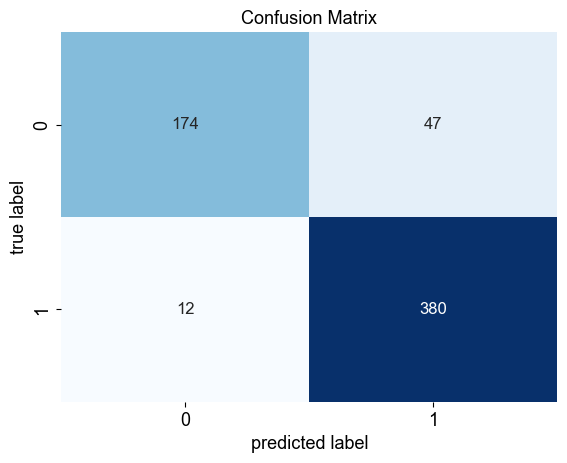

In [39]:
plot_cm(test_labels, grid_predictions, best_model)

#### B. TF-IDF n-grams

In [40]:
dfm_train, dfm_test = get_dfm(ngram_vectorizer, train_df_binary, test_df_binary)
train_text, train_labels, test_text, test_labels = dfm_train, train_df_binary['binary_label'], dfm_test, test_df_binary['binary_label']

train dfm shape: (3310, 74265) | test dfm shape:(613, 74265)


In [41]:
lg_grid_bin_ngram = GridSearchCV(LogisticRegression(random_state=999, max_iter=1000), parameters, refit = True, verbose = 3, cv=cv)
lg_grid_bin_ngram.fit(train_text, train_labels)

Fitting 15 folds for each of 45 candidates, totalling 675 fits
[CV 1/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.847 total time=   0.0s
[CV 2/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.805 total time=   0.0s
[CV 3/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.843 total time=   0.0s
[CV 4/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.872 total time=   0.0s
[CV 5/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.846 total time=   0.0s
[CV 6/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.826 total time=   0.0s
[CV 7/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.869 total time=   0.0s
[CV 8/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.843 total time=   0.0s
[CV 9/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.823 total time=   0.0s
[CV 10/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.852 total time=   0.0s
[CV 11/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.826 total time=   0.0s
[CV 12/15] END C=0.1, 

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/15] END C=10, penalty=l1, solver=liblinear;, score=0.881 total time=  33.2s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/15] END C=10, penalty=l1, solver=liblinear;, score=0.841 total time=  39.8s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/15] END C=10, penalty=l1, solver=liblinear;, score=0.875 total time=  37.7s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/15] END C=10, penalty=l1, solver=liblinear;, score=0.911 total time=  37.5s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/15] END C=10, penalty=l1, solver=liblinear;, score=0.869 total time=  34.4s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/15] END C=10, penalty=l1, solver=liblinear;, score=0.853 total time=  38.4s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/15] END C=10, penalty=l1, solver=liblinear;, score=0.903 total time=  37.9s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/15] END C=10, penalty=l1, solver=liblinear;, score=0.879 total time=  38.5s
[CV 9/15] END C=10, penalty=l1, solver=liblinear;, score=0.870 total time=   0.0s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/15] END C=10, penalty=l1, solver=liblinear;, score=0.891 total time=  37.9s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 11/15] END C=10, penalty=l1, solver=liblinear;, score=0.858 total time=  37.8s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 12/15] END C=10, penalty=l1, solver=liblinear;, score=0.893 total time=  37.5s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 13/15] END C=10, penalty=l1, solver=liblinear;, score=0.849 total time=  36.4s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 14/15] END C=10, penalty=l1, solver=liblinear;, score=0.897 total time=  37.4s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 15/15] END C=10, penalty=l1, solver=liblinear;, score=0.882 total time=  35.6s
[CV 1/15] END .....C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/15] END .....C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/15] END .....C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/15] END .....C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/15] END .....C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 6/15] END .....C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 7/15] END .....C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 8/15] END .....C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 9/15] END .....C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 10/15] END ....C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 11/15] END ....C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 12/15] END ....C=10, p

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/15] END ....C=10, penalty=l1, solver=saga;, score=0.879 total time=  24.3s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/15] END ....C=10, penalty=l1, solver=saga;, score=0.841 total time=  28.4s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/15] END ....C=10, penalty=l1, solver=saga;, score=0.876 total time=  31.6s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/15] END ....C=10, penalty=l1, solver=saga;, score=0.911 total time=  29.2s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/15] END ....C=10, penalty=l1, solver=saga;, score=0.866 total time=  25.6s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/15] END ....C=10, penalty=l1, solver=saga;, score=0.853 total time=  29.2s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/15] END ....C=10, penalty=l1, solver=saga;, score=0.903 total time=  27.1s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/15] END ....C=10, penalty=l1, solver=saga;, score=0.876 total time=  30.0s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/15] END ....C=10, penalty=l1, solver=saga;, score=0.869 total time=  24.1s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/15] END ...C=10, penalty=l1, solver=saga;, score=0.890 total time=  29.2s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 11/15] END ...C=10, penalty=l1, solver=saga;, score=0.860 total time=  27.8s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 12/15] END ...C=10, penalty=l1, solver=saga;, score=0.891 total time=  34.0s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 13/15] END ...C=10, penalty=l1, solver=saga;, score=0.849 total time=  28.6s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 14/15] END ...C=10, penalty=l1, solver=saga;, score=0.900 total time=  27.8s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 15/15] END ...C=10, penalty=l1, solver=saga;, score=0.881 total time=  25.7s
[CV 1/15] END C=10, penalty=l2, solver=liblinear;, score=0.856 total time=   0.1s
[CV 2/15] END C=10, penalty=l2, solver=liblinear;, score=0.810 total time=   0.3s
[CV 3/15] END C=10, penalty=l2, solver=liblinear;, score=0.852 total time=   0.3s
[CV 4/15] END C=10, penalty=l2, solver=liblinear;, score=0.882 total time=   0.4s
[CV 5/15] END C=10, penalty=l2, solver=liblinear;, score=0.856 total time=   0.2s
[CV 6/15] END C=10, penalty=l2, solver=liblinear;, score=0.832 total time=   0.1s
[CV 7/15] END C=10, penalty=l2, solver=liblinear;, score=0.881 total time=   0.1s
[CV 8/15] END C=10, penalty=l2, solver=liblinear;, score=0.855 total time=   0.1s
[CV 9/15] END C=10, penalty=l2, solver=liblinear;, score=0.832 total time=   0.1s
[CV 10/15] END C=10, penalty=l2, solver=liblinear;, score=0.863 total time=   0.1s
[CV 11/15] END C=10, penalty=l2, solver=liblinear;, score=0.837 total time=   0.1s
[CV 12/15] END 

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/15] END C=100, penalty=l1, solver=liblinear;, score=0.841 total time= 1.1min


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/15] END C=100, penalty=l1, solver=liblinear;, score=0.875 total time= 1.1min


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/15] END C=100, penalty=l1, solver=liblinear;, score=0.911 total time= 1.2min


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/15] END C=100, penalty=l1, solver=liblinear;, score=0.870 total time=  58.8s
[CV 6/15] END C=100, penalty=l1, solver=liblinear;, score=0.858 total time=   0.0s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/15] END C=100, penalty=l1, solver=liblinear;, score=0.908 total time= 1.1min


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/15] END C=100, penalty=l1, solver=liblinear;, score=0.887 total time= 1.2min


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/15] END C=100, penalty=l1, solver=liblinear;, score=0.875 total time=  58.0s
[CV 10/15] END C=100, penalty=l1, solver=liblinear;, score=0.894 total time=   0.0s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 11/15] END C=100, penalty=l1, solver=liblinear;, score=0.864 total time=  56.7s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 12/15] END C=100, penalty=l1, solver=liblinear;, score=0.899 total time= 1.1min


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 13/15] END C=100, penalty=l1, solver=liblinear;, score=0.850 total time=  58.3s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 14/15] END C=100, penalty=l1, solver=liblinear;, score=0.902 total time= 1.3min
[CV 15/15] END C=100, penalty=l1, solver=liblinear;, score=0.884 total time=   0.0s
[CV 1/15] END ....C=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/15] END ....C=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/15] END ....C=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/15] END ....C=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/15] END ....C=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 6/15] END ....C=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 7/15] END ....C=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 8/15] END ....C=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 9/15] END ....C=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 10/15] END ...C=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 11/15] END ...C=10

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/15] END ...C=100, penalty=l1, solver=saga;, score=0.878 total time= 1.0min


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/15] END ...C=100, penalty=l1, solver=saga;, score=0.843 total time= 1.1min


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/15] END ...C=100, penalty=l1, solver=saga;, score=0.879 total time= 1.1min


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/15] END ...C=100, penalty=l1, solver=saga;, score=0.906 total time= 1.2min


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/15] END ...C=100, penalty=l1, solver=saga;, score=0.866 total time= 1.1min


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/15] END ...C=100, penalty=l1, solver=saga;, score=0.853 total time= 1.0min


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/15] END ...C=100, penalty=l1, solver=saga;, score=0.903 total time= 1.1min


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/15] END ...C=100, penalty=l1, solver=saga;, score=0.888 total time= 1.1min


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/15] END ...C=100, penalty=l1, solver=saga;, score=0.864 total time= 1.0min


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/15] END ..C=100, penalty=l1, solver=saga;, score=0.894 total time= 1.1min


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 11/15] END ..C=100, penalty=l1, solver=saga;, score=0.867 total time= 1.1min


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 12/15] END ..C=100, penalty=l1, solver=saga;, score=0.888 total time= 1.1min


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 13/15] END ..C=100, penalty=l1, solver=saga;, score=0.850 total time= 1.0min


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 14/15] END ..C=100, penalty=l1, solver=saga;, score=0.902 total time= 1.1min


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 15/15] END ..C=100, penalty=l1, solver=saga;, score=0.884 total time= 1.1min
[CV 1/15] END C=100, penalty=l2, solver=liblinear;, score=0.863 total time=   0.3s
[CV 2/15] END C=100, penalty=l2, solver=liblinear;, score=0.819 total time=   0.1s
[CV 3/15] END C=100, penalty=l2, solver=liblinear;, score=0.861 total time=   0.1s
[CV 4/15] END C=100, penalty=l2, solver=liblinear;, score=0.891 total time=   0.1s
[CV 5/15] END C=100, penalty=l2, solver=liblinear;, score=0.861 total time=   0.1s
[CV 6/15] END C=100, penalty=l2, solver=liblinear;, score=0.835 total time=   0.1s
[CV 7/15] END C=100, penalty=l2, solver=liblinear;, score=0.890 total time=   0.0s
[CV 8/15] END C=100, penalty=l2, solver=liblinear;, score=0.861 total time=   0.1s
[CV 9/15] END C=100, penalty=l2, solver=liblinear;, score=0.840 total time=   0.0s
[CV 10/15] END C=100, penalty=l2, solver=liblinear;, score=0.870 total time=   0.0s
[CV 11/15] END C=100, penalty=l2, solver=liblinear;, score=0.846 total time=   0.0s
[CV 

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/15] END ..C=1000, penalty=l1, solver=saga;, score=0.881 total time= 5.6min


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/15] END ..C=1000, penalty=l1, solver=saga;, score=0.835 total time= 5.6min


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/15] END ..C=1000, penalty=l1, solver=saga;, score=0.884 total time= 5.5min


In [ ]:
print(lg_grid_bin_ngram.best_params_)
best_model = lg_grid_bin_ngram.best_estimator_

In [ ]:
grid_predictions = lg_grid_bin_ngram.predict(test_text)
print(classification_report(test_labels, grid_predictions))

In [ ]:
plot_cm(test_labels, grid_predictions, best_model)

#### C. GloVe embeddings

In [35]:
dfm_train, dfm_test = get_dfm(vectorizer, train_df_binary, test_df_binary)
doc_matrix_train = dfm_train[:,vocab_ids].dot(embed_matrix.loc[common_features,])
doc_matrix_test = dfm_test[:,vocab_ids].dot(embed_matrix.loc[common_features,])

train dfm shape: (3310, 5268) | test dfm shape:(613, 5268)


/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_21693/3597952091.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  doc_matrix_train = dfm_train[:,vocab_ids].dot(embed_matrix.loc[common_features,])
/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_21693/3597952091.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  doc_matrix_test = dfm_test[:,vocab_ids].dot(embed_matrix.loc[common_features,])


In [36]:
train_text, train_labels, test_text, test_labels = doc_matrix_train, train_df_binary['binary_label'], doc_matrix_test, test_df_binary['binary_label']

In [37]:
lg_grid_bin_glove = GridSearchCV(LogisticRegression(random_state=999, max_iter=1000), parameters, refit = True, verbose = 3, cv=cv)
lg_grid_bin_glove.fit(train_text, train_labels)

Fitting 15 folds for each of 30 candidates, totalling 450 fits
[CV 1/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.906 total time=   0.3s
[CV 2/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.869 total time=   0.3s
[CV 3/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.897 total time=   0.3s
[CV 4/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.920 total time=   0.4s
[CV 5/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.891 total time=   0.3s
[CV 6/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.887 total time=   0.3s
[CV 7/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.908 total time=   0.3s
[CV 8/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.894 total time=   0.5s
[CV 9/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.876 total time=   0.3s
[CV 10/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.903 total time=   0.4s
[CV 11/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.896 total time=   0.3s
[CV 12/15] END C=0.1, 

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/15] END .C=1000, penalty=l2, solver=lbfgs;, score=0.887 total time=   2.0s
[CV 7/15] END .C=1000, penalty=l2, solver=lbfgs;, score=0.897 total time=   2.1s
[CV 8/15] END .C=1000, penalty=l2, solver=lbfgs;, score=0.887 total time=   3.2s
[CV 9/15] END .C=1000, penalty=l2, solver=lbfgs;, score=0.879 total time=   1.9s
[CV 10/15] END C=1000, penalty=l2, solver=lbfgs;, score=0.896 total time=   2.1s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 11/15] END C=1000, penalty=l2, solver=lbfgs;, score=0.887 total time=   2.4s
[CV 12/15] END C=1000, penalty=l2, solver=lbfgs;, score=0.875 total time=   4.0s
[CV 13/15] END C=1000, penalty=l2, solver=lbfgs;, score=0.878 total time=   2.5s
[CV 14/15] END C=1000, penalty=l2, solver=lbfgs;, score=0.902 total time=   2.5s
[CV 15/15] END C=1000, penalty=l2, solver=lbfgs;, score=0.879 total time=   1.6s
[CV 1/15] END C=1000, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 2/15] END C=1000, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 3/15] END C=1000, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 4/15] END C=1000, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 5/15] END C=1000, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 6/15] END C=1000, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 7/15] END C=1000, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 8/1

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
225 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/janinedevera/op

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=LogisticRegression(max_iter=1000, random_state=999),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'None'],
                         'solver': ['liblinear', 'lbfgs']},
             verbose=3)

In [38]:
print(lg_grid_bin_glove.best_params_)
best_model = lg_grid_bin_glove.best_estimator_

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [39]:
grid_predictions = lg_grid_bin_glove.predict(test_text)
print(classification_report(test_labels, grid_predictions))

              precision    recall  f1-score   support

           0       0.84      0.46      0.60       221
           1       0.76      0.95      0.84       392

    accuracy                           0.77       613
   macro avg       0.80      0.71      0.72       613
weighted avg       0.79      0.77      0.75       613



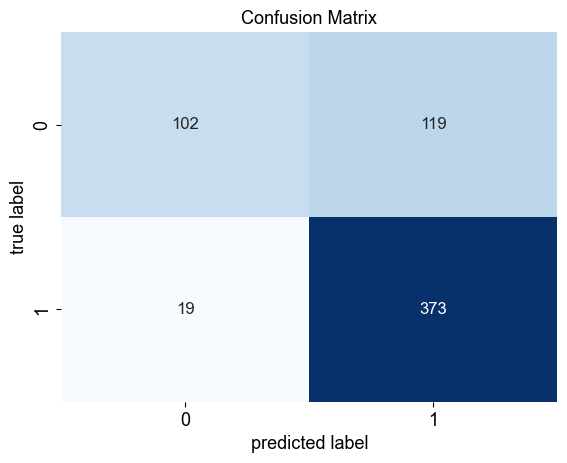

In [40]:
plot_cm(test_labels, grid_predictions, best_model)

#### D. Legalw2v embeddings

In [41]:
doc_matrix_train = doc_matrix_w2v(dfm_train)
doc_matrix_test = doc_matrix_w2v(dfm_test)

train_text, train_labels, test_text, test_labels = doc_matrix_train, train_df_binary['binary_label'], doc_matrix_test, test_df_binary['binary_label']

In [42]:
lg_grid_bin_legal = GridSearchCV(LogisticRegression(random_state=999, max_iter=1000), parameters, refit = True, verbose = 3, cv=cv)
lg_grid_bin_legal.fit(train_text, train_labels)

Fitting 15 folds for each of 30 candidates, totalling 450 fits
[CV 1/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.896 total time=   0.1s
[CV 2/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.893 total time=   0.1s
[CV 3/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.905 total time=   0.1s
[CV 4/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.912 total time=   0.1s
[CV 5/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.893 total time=   0.1s
[CV 6/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.905 total time=   0.1s
[CV 7/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.902 total time=   0.1s
[CV 8/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.899 total time=   0.1s
[CV 9/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.887 total time=   0.1s
[CV 10/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.897 total time=   0.1s
[CV 11/15] END C=0.1, penalty=l1, solver=liblinear;, score=0.882 total time=   0.1s
[CV 12/15] END C=0.1, 

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
225 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/janinedevera/op

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=LogisticRegression(max_iter=1000, random_state=999),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'None'],
                         'solver': ['liblinear', 'lbfgs']},
             verbose=3)

In [43]:
print(lg_grid_bin_legal.best_params_)
best_model = lg_grid_bin_legal.best_estimator_

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


In [44]:
grid_predictions = lg_grid_bin_legal.predict(test_text)
print(classification_report(test_labels, grid_predictions))

              precision    recall  f1-score   support

           0       0.85      0.49      0.62       221
           1       0.77      0.95      0.85       392

    accuracy                           0.79       613
   macro avg       0.81      0.72      0.74       613
weighted avg       0.80      0.79      0.77       613



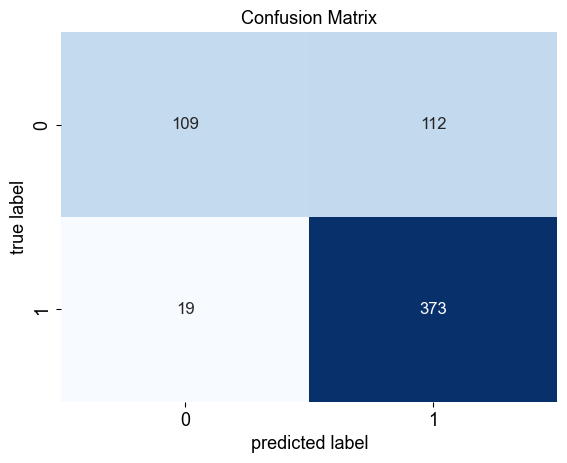

In [45]:
plot_cm(test_labels, grid_predictions, best_model)

### VIII. Softmax Hyperparameter Tuning

In [47]:
# define hyperparameters
parameters = {'C': [0.1, 1, 10, 100, 1000], 
              'penalty':  ['l1', 'l2', 'None'],
              'multi_class': ['auto', 'ovr', 'multinomial']}

# k-fold validation 
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=999)

#### A. TF-IDF uni-grams

In [48]:
dfm_train, dfm_test = get_dfm(vectorizer, train_df_aug, test_df)
train_text, train_labels, test_text, test_labels = dfm_train, train_df_aug['Category_New'], dfm_test, test_df['Category_New']

train dfm shape: (3445, 5268) | test dfm shape:(708, 5268)


In [49]:
lg_grid_multi_uni = GridSearchCV(LogisticRegression(random_state=999, max_iter=1000), parameters, refit = True, verbose = 3, cv=cv)
lg_grid_multi_uni.fit(train_text, train_labels)

Fitting 15 folds for each of 45 candidates, totalling 675 fits
[CV 1/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 2/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 3/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 4/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 5/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 6/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 7/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 8/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 9/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 10/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 11/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 12/15] END C=0.1, multi_class=auto, pena

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
450 fits failed out of a total of 675.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
225 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/janinedevera/o

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=LogisticRegression(max_iter=1000, random_state=999),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'multi_class': ['auto', 'ovr', 'multinomial'],
                         'penalty': ['l1', 'l2', 'None']},
             verbose=3)

In [50]:
print(lg_grid_multi_uni.best_params_)
best_model = lg_grid_multi_uni.best_estimator_

{'C': 10, 'multi_class': 'ovr', 'penalty': 'l2'}


In [51]:
grid_predictions = lg_grid_multi_uni.predict(test_text)
print(classification_report(test_labels, grid_predictions))

              precision    recall  f1-score   support

           A       0.88      0.78      0.83       376
           B       0.38      0.60      0.47        68
           C       0.43      0.50      0.46        18
        None       0.93      0.84      0.88       225
      Others       0.24      0.43      0.31        21

    accuracy                           0.77       708
   macro avg       0.57      0.63      0.59       708
weighted avg       0.82      0.77      0.79       708



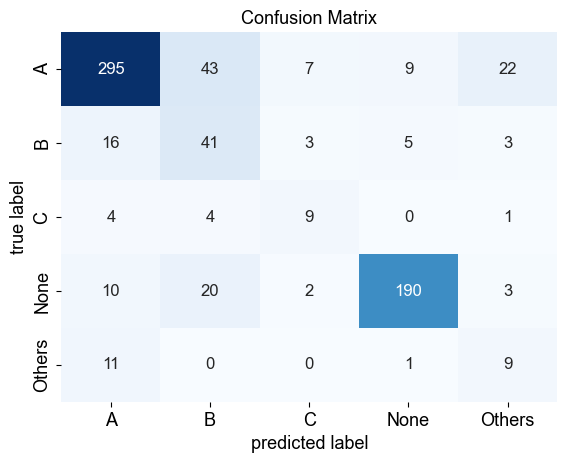

In [52]:
plot_cm(test_labels, grid_predictions, best_model)

#### B. TF-IDF n-grams

In [53]:
dfm_train, dfm_test = get_dfm(ngram_vectorizer, train_df_aug, test_df)
train_text, train_labels, test_text, test_labels = dfm_train, train_df_aug['Category_New'], dfm_test, test_df['Category_New']

train dfm shape: (3445, 74265) | test dfm shape:(708, 74265)


In [54]:
lg_grid_multi_ngram = GridSearchCV(LogisticRegression(random_state=999, max_iter=1000), parameters, refit = True, verbose = 3, cv=cv)
lg_grid_multi_ngram.fit(train_text, train_labels)

Fitting 15 folds for each of 45 candidates, totalling 675 fits
[CV 1/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 2/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 3/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 4/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 5/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 6/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 7/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 8/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 9/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 10/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 11/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 12/15] END C=0.1, multi_class=auto, pena

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
450 fits failed out of a total of 675.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
225 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/janinedevera/o

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=LogisticRegression(max_iter=1000, random_state=999),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'multi_class': ['auto', 'ovr', 'multinomial'],
                         'penalty': ['l1', 'l2', 'None']},
             verbose=3)

In [55]:
print(lg_grid_multi_ngram.best_params_)
best_model = lg_grid_multi_ngram.best_estimator_

{'C': 100, 'multi_class': 'auto', 'penalty': 'l2'}


In [56]:
grid_predictions = lg_grid_multi_ngram.predict(test_text)
print(classification_report(test_labels, grid_predictions))

              precision    recall  f1-score   support

           A       0.87      0.76      0.81       376
           B       0.27      0.66      0.39        68
           C       0.46      0.33      0.39        18
        None       0.94      0.74      0.83       225
      Others       0.17      0.19      0.18        21

    accuracy                           0.72       708
   macro avg       0.54      0.54      0.52       708
weighted avg       0.80      0.72      0.75       708



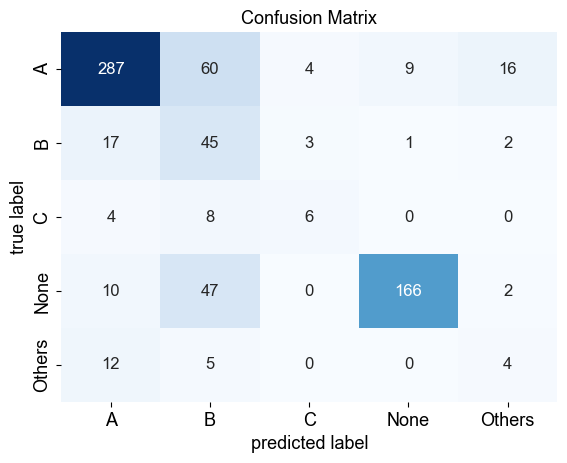

In [57]:
plot_cm(test_labels, grid_predictions, best_model)

#### C. GloVe embeddings

In [58]:
dfm_train, dfm_test = get_dfm(vectorizer, train_df_aug, test_df)
doc_matrix_train = dfm_train[:,vocab_ids].dot(embed_matrix.loc[common_features,])
doc_matrix_test = dfm_test[:,vocab_ids].dot(embed_matrix.loc[common_features,])

train dfm shape: (3445, 5268) | test dfm shape:(708, 5268)


/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_21693/3399062756.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  doc_matrix_train = dfm_train[:,vocab_ids].dot(embed_matrix.loc[common_features,])
/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_21693/3399062756.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  doc_matrix_test = dfm_test[:,vocab_ids].dot(embed_matrix.loc[common_features,])


In [59]:
train_text, train_labels, test_text, test_labels = doc_matrix_train, train_df_aug['Category_New'], doc_matrix_test, test_df['Category_New']

In [60]:
lg_grid_multi_glove = GridSearchCV(LogisticRegression(random_state=999, max_iter=1000), parameters, refit = True, verbose = 3, cv=cv)
lg_grid_multi_glove.fit(train_text, train_labels)

Fitting 15 folds for each of 45 candidates, totalling 675 fits
[CV 1/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 2/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 3/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 4/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 5/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 6/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 7/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 8/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 9/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 10/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 11/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 12/15] END C=0.1, multi_class=auto, pena

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/15] END C=10, multi_class=auto, penalty=l2;, score=0.701 total time=   5.8s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/15] END C=10, multi_class=auto, penalty=l2;, score=0.676 total time=   4.6s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/15] END C=10, multi_class=auto, penalty=l2;, score=0.682 total time=   5.1s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/15] END C=10, multi_class=auto, penalty=l2;, score=0.692 total time=   5.1s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/15] END C=10, multi_class=auto, penalty=l2;, score=0.708 total time=   4.5s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/15] END C=10, multi_class=auto, penalty=l2;, score=0.662 total time=   8.0s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 7/15] END C=10, multi_class=auto, penalty=l2;, score=0.717 total time=  10.5s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 8/15] END C=10, multi_class=auto, penalty=l2;, score=0.691 total time=   4.3s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 9/15] END C=10, multi_class=auto, penalty=l2;, score=0.687 total time=   4.1s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 10/15] END C=10, multi_class=auto, penalty=l2;, score=0.702 total time=   5.8s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 11/15] END C=10, multi_class=auto, penalty=l2;, score=0.681 total time=   5.2s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 12/15] END C=10, multi_class=auto, penalty=l2;, score=0.710 total time=   3.6s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 13/15] END C=10, multi_class=auto, penalty=l2;, score=0.717 total time=   4.1s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 14/15] END C=10, multi_class=auto, penalty=l2;, score=0.691 total time=   7.1s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 15/15] END C=10, multi_class=auto, penalty=l2;, score=0.697 total time=   6.7s
[CV 1/15] END C=10, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 2/15] END C=10, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 3/15] END C=10, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 4/15] END C=10, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 5/15] END C=10, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 6/15] END C=10, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 7/15] END C=10, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 8/15] END C=10, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 9/15] END C=10, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 10/15] END C=10, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 11/15] END C=10, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 12/15] EN

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/15] END C=10, multi_class=multinomial, penalty=l2;, score=0.701 total time=   4.6s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/15] END C=10, multi_class=multinomial, penalty=l2;, score=0.676 total time=   5.1s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/15] END C=10, multi_class=multinomial, penalty=l2;, score=0.682 total time=   7.0s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/15] END C=10, multi_class=multinomial, penalty=l2;, score=0.692 total time=   5.0s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/15] END C=10, multi_class=multinomial, penalty=l2;, score=0.708 total time=   4.7s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/15] END C=10, multi_class=multinomial, penalty=l2;, score=0.662 total time=   3.7s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 7/15] END C=10, multi_class=multinomial, penalty=l2;, score=0.717 total time=   4.2s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 8/15] END C=10, multi_class=multinomial, penalty=l2;, score=0.691 total time=   4.2s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 9/15] END C=10, multi_class=multinomial, penalty=l2;, score=0.687 total time=   3.2s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 10/15] END C=10, multi_class=multinomial, penalty=l2;, score=0.702 total time=   4.0s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 11/15] END C=10, multi_class=multinomial, penalty=l2;, score=0.681 total time=   4.8s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 12/15] END C=10, multi_class=multinomial, penalty=l2;, score=0.710 total time=   4.3s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 13/15] END C=10, multi_class=multinomial, penalty=l2;, score=0.717 total time=   4.6s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 14/15] END C=10, multi_class=multinomial, penalty=l2;, score=0.691 total time=   4.5s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 15/15] END C=10, multi_class=multinomial, penalty=l2;, score=0.697 total time=   4.0s
[CV 1/15] END C=10, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 2/15] END C=10, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 3/15] END C=10, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 4/15] END C=10, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 5/15] END C=10, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 6/15] END C=10, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 7/15] END C=10, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 8/15] END C=10, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 9/15] END C=10, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 10/15] END C=10, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 11/15] END C=10

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/15] END C=100, multi_class=auto, penalty=l2;, score=0.673 total time=   4.5s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/15] END C=100, multi_class=auto, penalty=l2;, score=0.656 total time=   4.8s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/15] END C=100, multi_class=auto, penalty=l2;, score=0.681 total time=   4.5s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/15] END C=100, multi_class=auto, penalty=l2;, score=0.676 total time=   5.7s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/15] END C=100, multi_class=auto, penalty=l2;, score=0.695 total time=   6.1s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/15] END C=100, multi_class=auto, penalty=l2;, score=0.642 total time=   4.0s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 7/15] END C=100, multi_class=auto, penalty=l2;, score=0.700 total time=   5.2s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 8/15] END C=100, multi_class=auto, penalty=l2;, score=0.672 total time=   6.2s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 9/15] END C=100, multi_class=auto, penalty=l2;, score=0.671 total time=   4.1s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 10/15] END C=100, multi_class=auto, penalty=l2;, score=0.695 total time=   5.8s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 11/15] END C=100, multi_class=auto, penalty=l2;, score=0.672 total time=   3.8s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 12/15] END C=100, multi_class=auto, penalty=l2;, score=0.681 total time=   4.7s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 13/15] END C=100, multi_class=auto, penalty=l2;, score=0.688 total time=   5.9s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 14/15] END C=100, multi_class=auto, penalty=l2;, score=0.656 total time=   4.4s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 15/15] END C=100, multi_class=auto, penalty=l2;, score=0.662 total time=   3.4s
[CV 1/15] END C=100, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 2/15] END C=100, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 3/15] END C=100, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 4/15] END C=100, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 5/15] END C=100, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 6/15] END C=100, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 7/15] END C=100, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 8/15] END C=100, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 9/15] END C=100, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 10/15] END C=100, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 11/15] END C=100, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/15] END C=100, multi_class=multinomial, penalty=l2;, score=0.673 total time=   4.3s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/15] END C=100, multi_class=multinomial, penalty=l2;, score=0.656 total time=   4.1s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/15] END C=100, multi_class=multinomial, penalty=l2;, score=0.681 total time=   4.8s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/15] END C=100, multi_class=multinomial, penalty=l2;, score=0.676 total time=   4.8s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/15] END C=100, multi_class=multinomial, penalty=l2;, score=0.695 total time=   3.9s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/15] END C=100, multi_class=multinomial, penalty=l2;, score=0.642 total time=   3.8s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 7/15] END C=100, multi_class=multinomial, penalty=l2;, score=0.700 total time=   4.0s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 8/15] END C=100, multi_class=multinomial, penalty=l2;, score=0.672 total time=   4.4s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 9/15] END C=100, multi_class=multinomial, penalty=l2;, score=0.671 total time=   3.8s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 10/15] END C=100, multi_class=multinomial, penalty=l2;, score=0.695 total time=   4.2s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 11/15] END C=100, multi_class=multinomial, penalty=l2;, score=0.672 total time=   6.5s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 12/15] END C=100, multi_class=multinomial, penalty=l2;, score=0.681 total time=   4.2s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 13/15] END C=100, multi_class=multinomial, penalty=l2;, score=0.688 total time=   4.8s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 14/15] END C=100, multi_class=multinomial, penalty=l2;, score=0.656 total time=   4.4s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 15/15] END C=100, multi_class=multinomial, penalty=l2;, score=0.662 total time=   6.5s
[CV 1/15] END C=100, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 2/15] END C=100, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 3/15] END C=100, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 4/15] END C=100, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 5/15] END C=100, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 6/15] END C=100, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 7/15] END C=100, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 8/15] END C=100, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 9/15] END C=100, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 10/15] END C=100, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 11/1

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/15] END C=1000, multi_class=auto, penalty=l2;, score=0.644 total time=   6.6s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/15] END C=1000, multi_class=auto, penalty=l2;, score=0.650 total time=   5.4s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/15] END C=1000, multi_class=auto, penalty=l2;, score=0.657 total time=   5.8s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/15] END C=1000, multi_class=auto, penalty=l2;, score=0.671 total time=   4.0s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/15] END C=1000, multi_class=auto, penalty=l2;, score=0.688 total time=   6.5s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/15] END C=1000, multi_class=auto, penalty=l2;, score=0.630 total time=   4.2s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 7/15] END C=1000, multi_class=auto, penalty=l2;, score=0.691 total time=   4.7s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 8/15] END C=1000, multi_class=auto, penalty=l2;, score=0.669 total time=   3.4s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 9/15] END C=1000, multi_class=auto, penalty=l2;, score=0.668 total time=   4.7s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 10/15] END C=1000, multi_class=auto, penalty=l2;, score=0.691 total time=   4.9s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 11/15] END C=1000, multi_class=auto, penalty=l2;, score=0.647 total time=   4.7s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 12/15] END C=1000, multi_class=auto, penalty=l2;, score=0.681 total time=   4.8s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 13/15] END C=1000, multi_class=auto, penalty=l2;, score=0.684 total time=   5.9s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 14/15] END C=1000, multi_class=auto, penalty=l2;, score=0.653 total time=   4.9s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 15/15] END C=1000, multi_class=auto, penalty=l2;, score=0.657 total time=   4.9s
[CV 1/15] END C=1000, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 2/15] END C=1000, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 3/15] END C=1000, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 4/15] END C=1000, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 5/15] END C=1000, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 6/15] END C=1000, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 7/15] END C=1000, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 8/15] END C=1000, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 9/15] END C=1000, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 10/15] END C=1000, multi_class=auto, penalty=None;, score=nan total time=   0.0s
[CV 11/15] END C=1000, multi_class=auto, penalty=None;, score=nan total ti

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/15] END C=1000, multi_class=ovr, penalty=l2;, score=0.695 total time=   9.7s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/15] END C=1000, multi_class=ovr, penalty=l2;, score=0.676 total time=   7.6s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/15] END C=1000, multi_class=ovr, penalty=l2;, score=0.702 total time=   7.1s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/15] END C=1000, multi_class=ovr, penalty=l2;, score=0.689 total time=   8.1s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/15] END C=1000, multi_class=ovr, penalty=l2;, score=0.723 total time=   8.4s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/15] END C=1000, multi_class=ovr, penalty=l2;, score=0.668 total time=   8.2s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 7/15] END C=1000, multi_class=ovr, penalty=l2;, score=0.721 total time=   8.4s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 8/15] END C=1000, multi_class=ovr, penalty=l2;, score=0.684 total time=  11.1s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 9/15] END C=1000, multi_class=ovr, penalty=l2;, score=0.714 total time=  11.5s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 10/15] END C=1000, multi_class=ovr, penalty=l2;, score=0.716 total time=  12.9s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 11/15] END C=1000, multi_class=ovr, penalty=l2;, score=0.671 total time=  14.2s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 12/15] END C=1000, multi_class=ovr, penalty=l2;, score=0.714 total time=  12.2s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 13/15] END C=1000, multi_class=ovr, penalty=l2;, score=0.718 total time=  12.3s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 14/15] END C=1000, multi_class=ovr, penalty=l2;, score=0.684 total time=   8.3s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 15/15] END C=1000, multi_class=ovr, penalty=l2;, score=0.700 total time=  10.5s
[CV 1/15] END C=1000, multi_class=ovr, penalty=None;, score=nan total time=   0.0s
[CV 2/15] END C=1000, multi_class=ovr, penalty=None;, score=nan total time=   0.0s
[CV 3/15] END C=1000, multi_class=ovr, penalty=None;, score=nan total time=   0.0s
[CV 4/15] END C=1000, multi_class=ovr, penalty=None;, score=nan total time=   0.0s
[CV 5/15] END C=1000, multi_class=ovr, penalty=None;, score=nan total time=   0.0s
[CV 6/15] END C=1000, multi_class=ovr, penalty=None;, score=nan total time=   0.0s
[CV 7/15] END C=1000, multi_class=ovr, penalty=None;, score=nan total time=   0.0s
[CV 8/15] END C=1000, multi_class=ovr, penalty=None;, score=nan total time=   0.0s
[CV 9/15] END C=1000, multi_class=ovr, penalty=None;, score=nan total time=   0.0s
[CV 10/15] END C=1000, multi_class=ovr, penalty=None;, score=nan total time=   0.0s
[CV 11/15] END C=1000, multi_class=ovr, penalty=None;, score=nan total time=   0.0s
[

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/15] END C=1000, multi_class=multinomial, penalty=l2;, score=0.644 total time=  10.6s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/15] END C=1000, multi_class=multinomial, penalty=l2;, score=0.650 total time=   5.2s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/15] END C=1000, multi_class=multinomial, penalty=l2;, score=0.657 total time=   5.3s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/15] END C=1000, multi_class=multinomial, penalty=l2;, score=0.671 total time=   6.4s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/15] END C=1000, multi_class=multinomial, penalty=l2;, score=0.688 total time=   6.6s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/15] END C=1000, multi_class=multinomial, penalty=l2;, score=0.630 total time=   5.1s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 7/15] END C=1000, multi_class=multinomial, penalty=l2;, score=0.691 total time=   4.9s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 8/15] END C=1000, multi_class=multinomial, penalty=l2;, score=0.669 total time=   4.3s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 9/15] END C=1000, multi_class=multinomial, penalty=l2;, score=0.668 total time=   7.7s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 10/15] END C=1000, multi_class=multinomial, penalty=l2;, score=0.691 total time=   6.4s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 11/15] END C=1000, multi_class=multinomial, penalty=l2;, score=0.647 total time=   5.0s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 12/15] END C=1000, multi_class=multinomial, penalty=l2;, score=0.681 total time=   6.1s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 13/15] END C=1000, multi_class=multinomial, penalty=l2;, score=0.684 total time=   6.1s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 14/15] END C=1000, multi_class=multinomial, penalty=l2;, score=0.653 total time=   7.1s


/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
450 fits failed out of a total of 675.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
-------------------------------------------------

[CV 15/15] END C=1000, multi_class=multinomial, penalty=l2;, score=0.657 total time=   5.1s
[CV 1/15] END C=1000, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 2/15] END C=1000, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 3/15] END C=1000, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 4/15] END C=1000, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 5/15] END C=1000, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 6/15] END C=1000, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 7/15] END C=1000, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 8/15] END C=1000, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 9/15] END C=1000, multi_class=multinomial, penalty=None;, score=nan total time=   0.0s
[CV 10/15] END C=1000, multi_class=multinomial, penalty=None;, score=nan total time=   0.

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=LogisticRegression(max_iter=1000, random_state=999),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'multi_class': ['auto', 'ovr', 'multinomial'],
                         'penalty': ['l1', 'l2', 'None']},
             verbose=3)

In [61]:
print(lg_grid_multi_glove.best_params_)
best_model = lg_grid_multi_glove.best_estimator_

{'C': 10, 'multi_class': 'ovr', 'penalty': 'l2'}


In [62]:
grid_predictions = lg_grid_multi_glove.predict(test_text)
print(classification_report(test_labels, grid_predictions))

              precision    recall  f1-score   support

           A       0.83      0.64      0.73       376
           B       0.30      0.65      0.41        68
           C       0.24      0.56      0.33        18
        None       0.83      0.63      0.71       225
      Others       0.14      0.38      0.20        21

    accuracy                           0.63       708
   macro avg       0.47      0.57      0.48       708
weighted avg       0.75      0.63      0.67       708



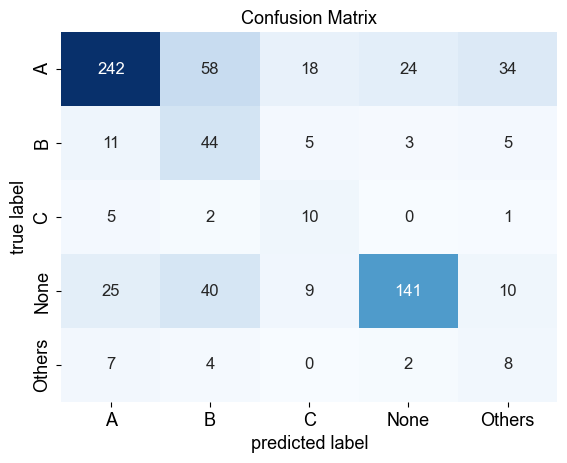

In [63]:
plot_cm(test_labels, grid_predictions, best_model)

#### D. Legalw2v embeddings

In [64]:
doc_matrix_train = doc_matrix_w2v(dfm_train)
doc_matrix_test = doc_matrix_w2v(dfm_test)

In [65]:
train_text, train_labels, test_text, test_labels = doc_matrix_train, train_df_aug['Category_New'], doc_matrix_test, test_df['Category_New']

In [66]:
lg_grid_multi_legal = GridSearchCV(LogisticRegression(random_state=999, max_iter=1000), parameters, refit = True, verbose = 3, cv=cv)
lg_grid_multi_legal.fit(train_text, train_labels)

Fitting 15 folds for each of 45 candidates, totalling 675 fits
[CV 1/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 2/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 3/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 4/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 5/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 6/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 7/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 8/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 9/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 10/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 11/15] END C=0.1, multi_class=auto, penalty=l1;, score=nan total time=   0.0s
[CV 12/15] END C=0.1, multi_class=auto, pena

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
450 fits failed out of a total of 675.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
225 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/janinedevera/o

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=LogisticRegression(max_iter=1000, random_state=999),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'multi_class': ['auto', 'ovr', 'multinomial'],
                         'penalty': ['l1', 'l2', 'None']},
             verbose=3)

In [67]:
print(lg_grid_multi_legal.best_params_)
best_model = lg_grid_multi_legal.best_estimator_

{'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l2'}


In [68]:
grid_predictions = lg_grid_multi_legal.predict(test_text)
print(classification_report(test_labels, grid_predictions))

              precision    recall  f1-score   support

           A       0.84      0.56      0.67       376
           B       0.27      0.57      0.36        68
           C       0.15      0.50      0.23        18
        None       0.79      0.60      0.68       225
      Others       0.14      0.52      0.22        21

    accuracy                           0.57       708
   macro avg       0.44      0.55      0.43       708
weighted avg       0.73      0.57      0.62       708



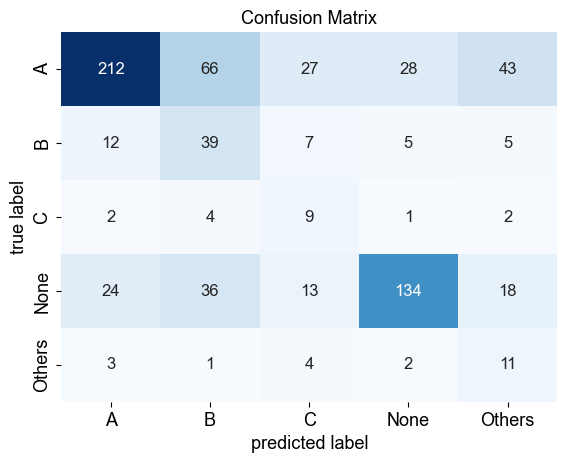

In [69]:
plot_cm(test_labels, grid_predictions, best_model)

### Feature visualizations

#### A. TF-IDF

In [923]:
dfm_train, dfm_test = get_dfm(vectorizer, train_df_binary, test_df_binary)

train dfm shape: (3310, 5268) | test dfm shape:(613, 5268)


In [924]:
def get_reduced_df(n_components, dfm, original_df):
    reducer = umap.UMAP(n_components=n_components)
    dfm_reduced = reducer.fit_transform(dfm)

    features = pd.DataFrame(dfm_reduced, columns=["f{}".format(i) for i in range(n_components)])
    df_reduced = pd.concat([original_df['binary_label'], features], axis=1)

    return df_reduced

In [ ]:
test_df_reduced = get_reduced_df(5, dfm_test, test_df_binary)
test_df_reduced = test_df_reduced.rename(columns={"f0": "dim 1", "f1": "dim 2", "f2": "dim 3", "f3": "dim 4", "f4": "dim 5"})
test_df_reduced["binary_label"] = test_df_reduced["binary_label"].replace({0: "no restrictions", 1: "with restrictions"})

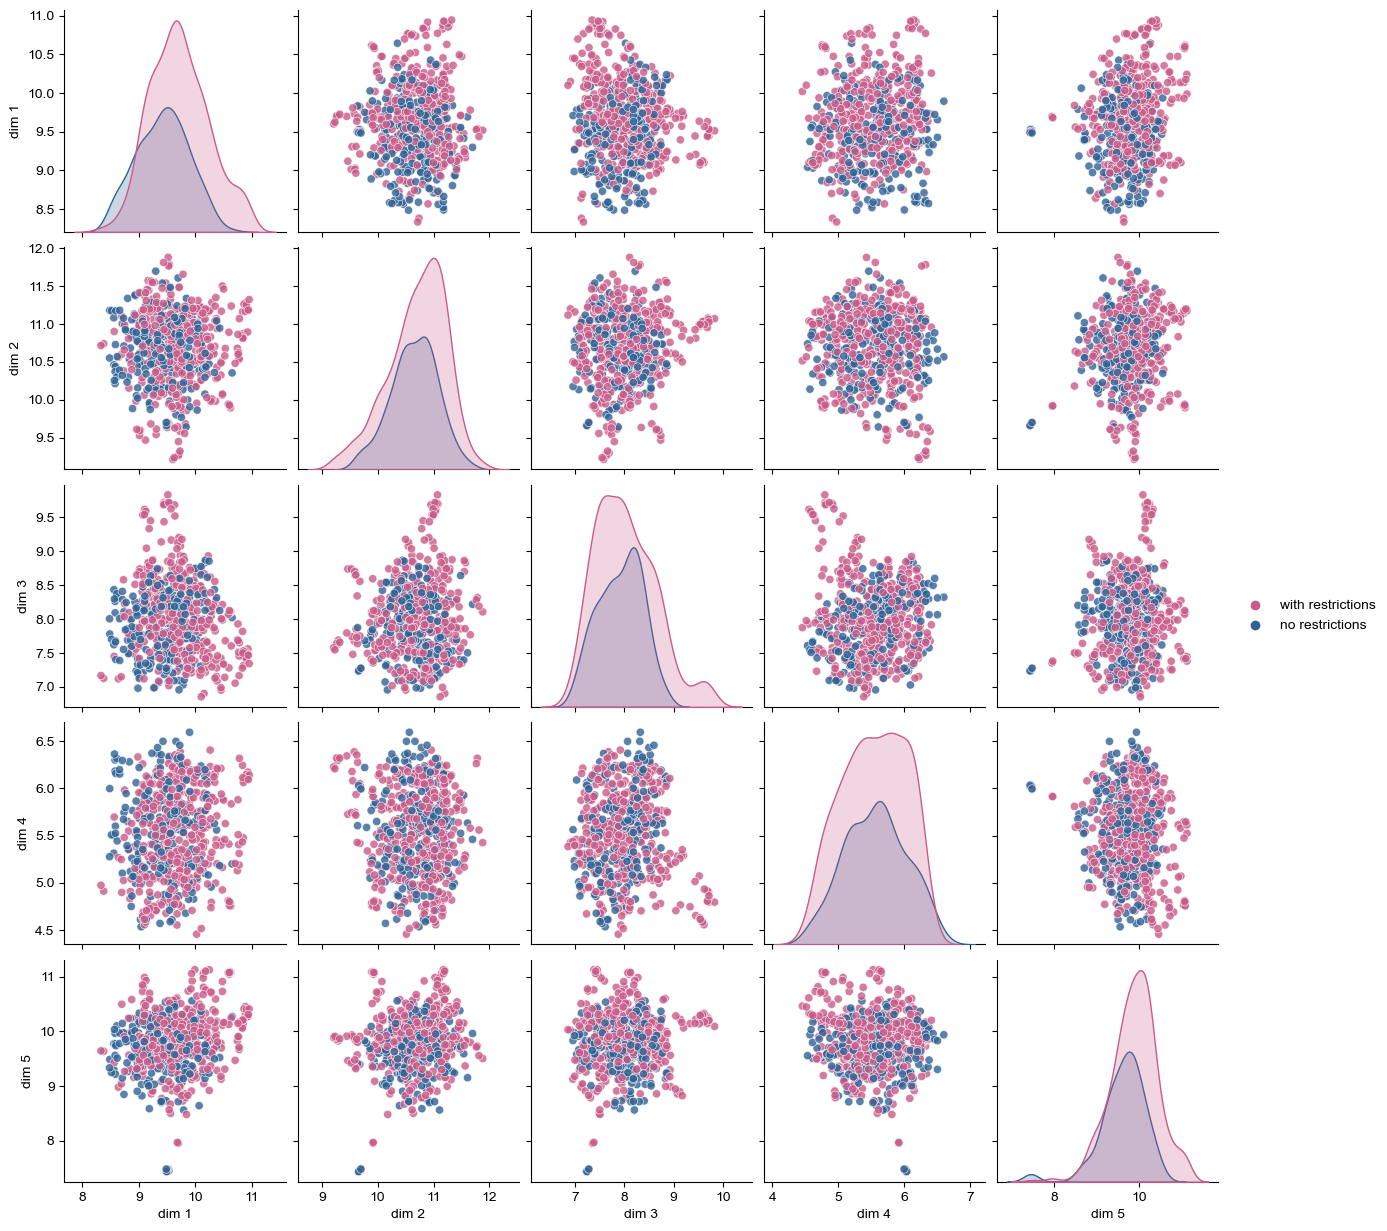

In [677]:
plt.rcParams["font.family"] = "Arial"
plot1 = sns.pairplot(test_df_reduced, kind="scatter", hue="binary_label", palette=two_colors, plot_kws={"alpha": 0.8})
plot1._legend.set_title('')
plt.show()

#### B. GloVe embeddings

In [689]:
doc_matrix_test = dfm_test[:,vocab_ids].dot(embed_matrix.loc[common_features,])

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_5629/1030511957.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  doc_matrix_test = dfm_test[:,vocab_ids].dot(embed_matrix.loc[common_features,])


In [692]:
test_df_reduced = get_reduced_df(5, doc_matrix_test, test_df_binary)
test_df_reduced = test_df_reduced.rename(columns={"f0": "dim 1", "f1": "dim 2", "f2": "dim 3", "f3": "dim 4", "f4": "dim 5"})
test_df_reduced["binary_label"] = test_df_reduced["binary_label"].replace({0: "no restrictions", 1: "with restrictions"})

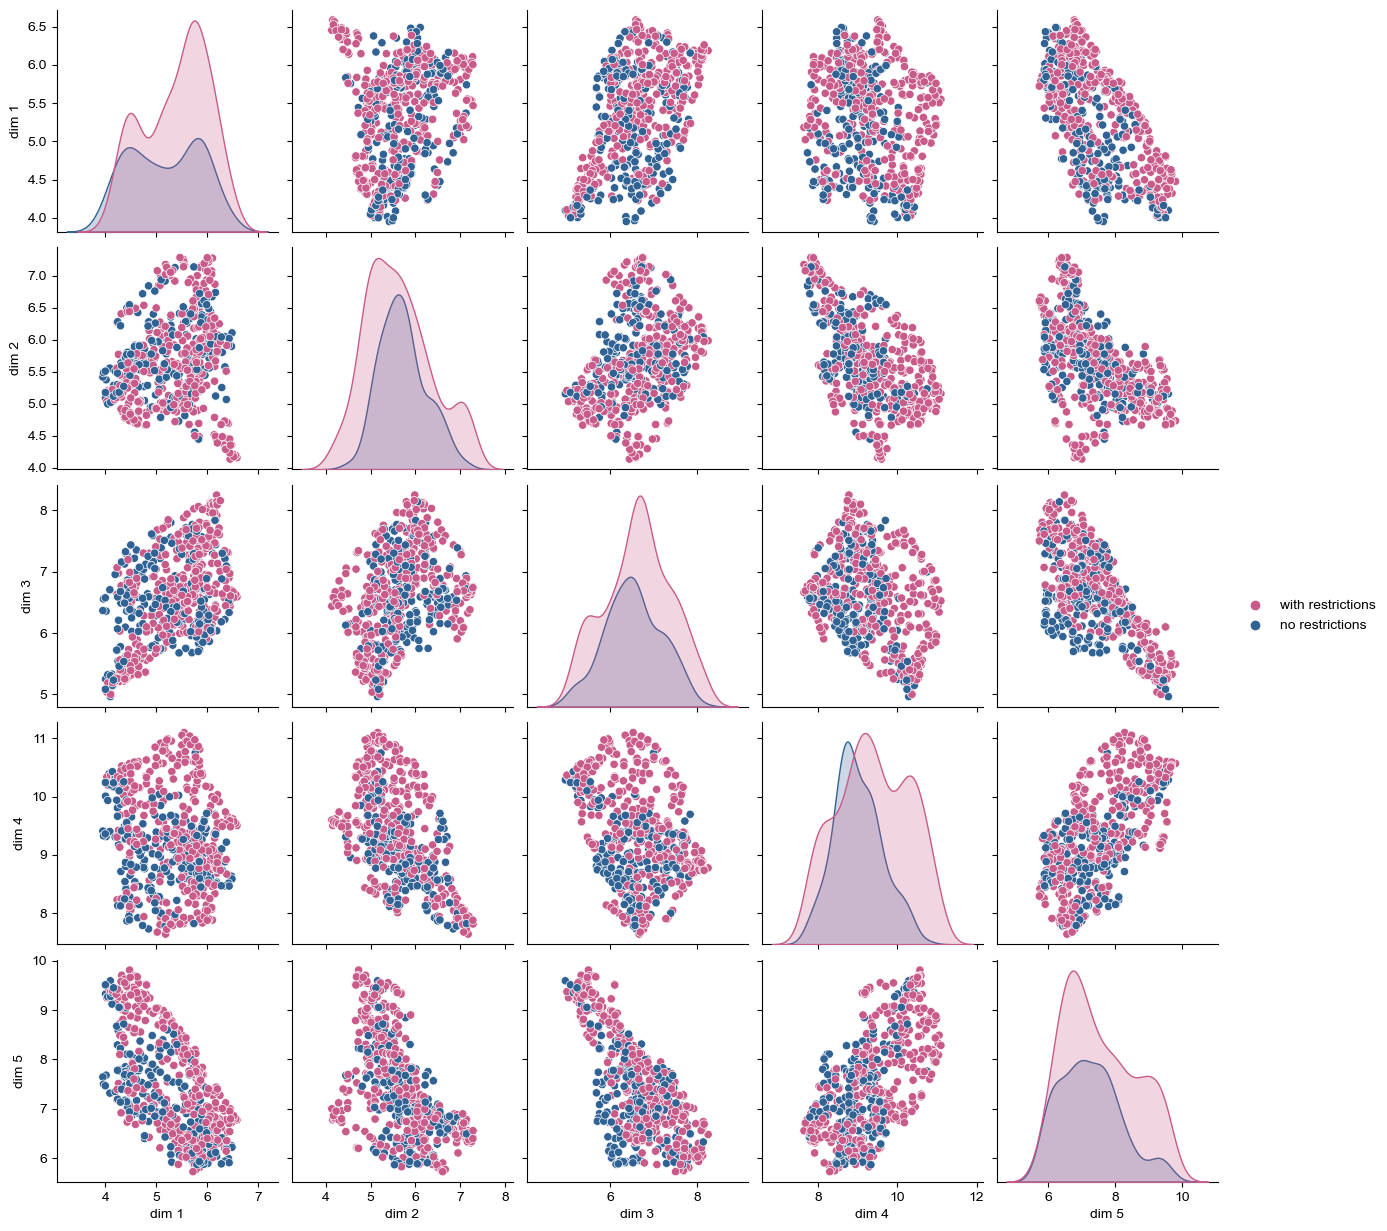

In [694]:
plt.rcParams["font.family"] = "Arial"
plot1 = sns.pairplot(test_df_reduced, kind="scatter", hue="binary_label", palette=two_colors)
plot1._legend.set_title('')

save_path = os.path.join('draft', 'images', 'plot05-06.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

#### C. Legalw2v

In [685]:
doc_matrix_test = doc_matrix_w2v(dfm_test)

In [686]:
test_df_reduced = get_reduced_df(5, doc_matrix_test, test_df_binary)
test_df_reduced = test_df_reduced.rename(columns={"f0": "dim 1", "f1": "dim 2", "f2": "dim 3", "f3": "dim 4", "f4": "dim 5"})
test_df_reduced["binary_label"] = test_df_reduced["binary_label"].replace({0: "no restrictions", 1: "with restrictions"})

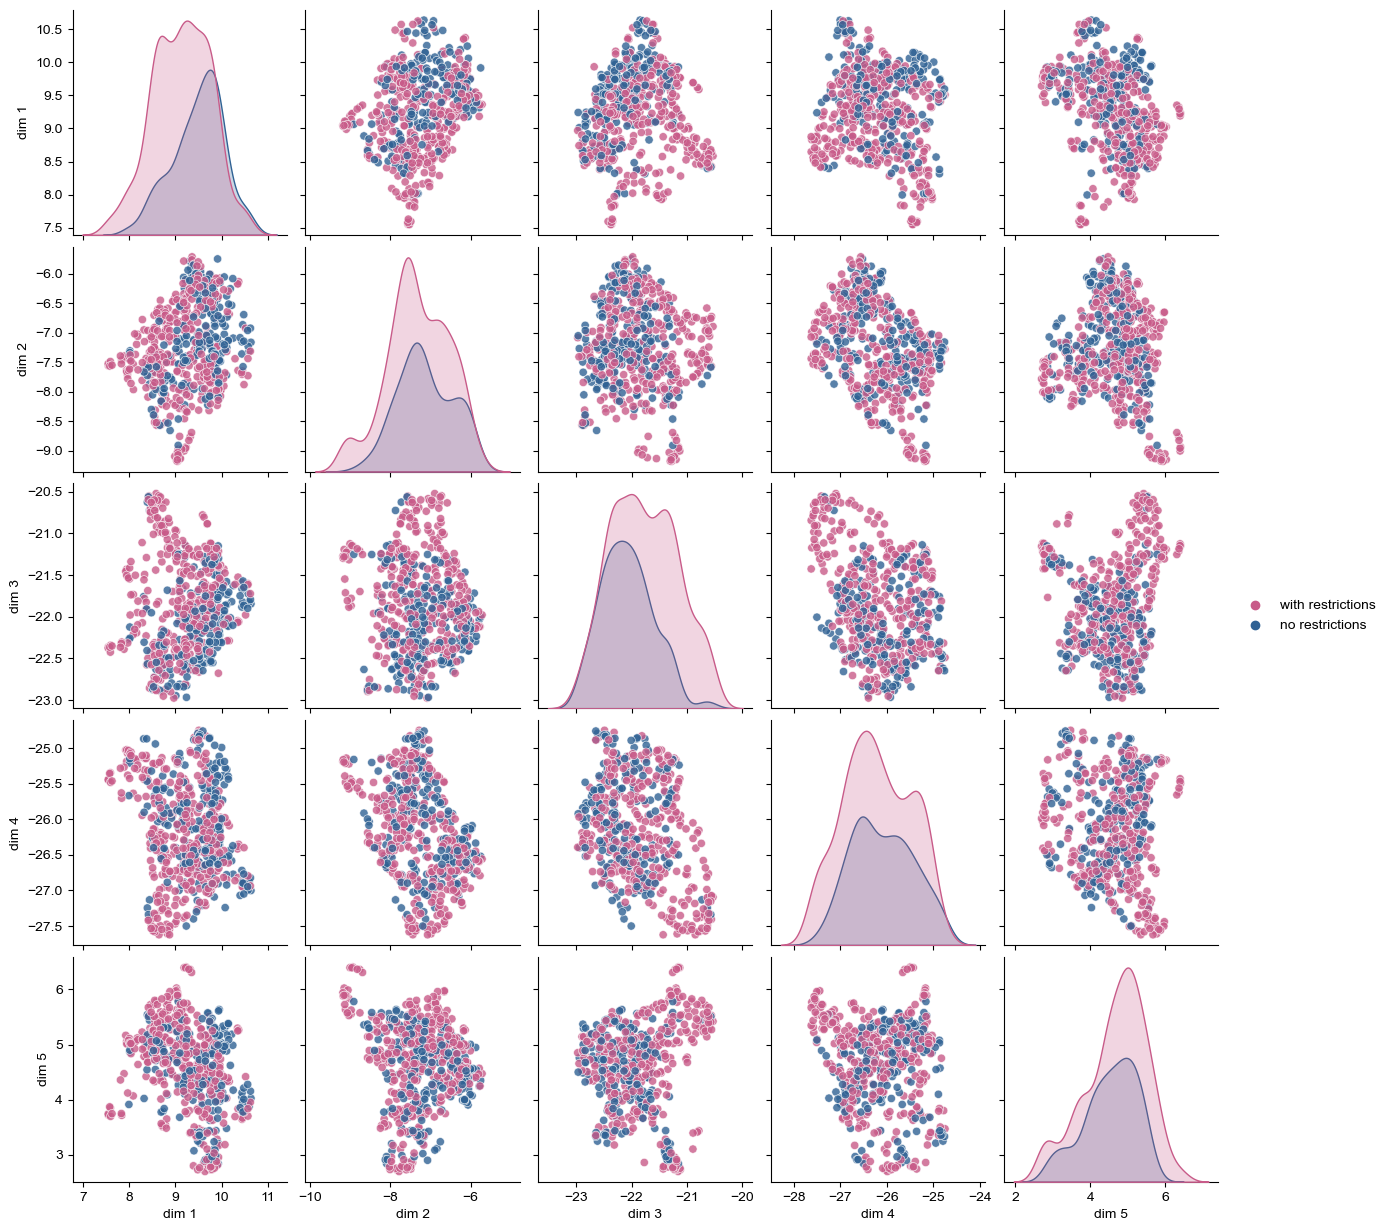

In [687]:
plt.rcParams["font.family"] = "Arial"
plot1 = sns.pairplot(test_df_reduced, kind="scatter", hue="binary_label", palette=two_colors, plot_kws={"alpha": 0.8})
plot1._legend.set_title('')
plt.show()